<a href="https://colab.research.google.com/github/BartoszMietlicki/probability-of-default/blob/main/probability_of_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Probability of Default (PD) Prediction Model**
___

#### **Author:** Bartosz Mietlicki  
#### **Project period:** December 2025  
___

___
## **0 – Project Introduction and Assumptions**
___


### **0.1 – Project objective**

The goal of this project is to build a predictive model that estimates a customer’s **Probability of Default (PD)** based on the provided data and to evaluate the final solution on a hold-out test set. The notebook presents a complete, end-to-end workflow: from data inspection, through preprocessing, to model selection and final evaluation.
___

### **0.2 – Input data**

The project uses two Parquet files: **pd_train.parquet** and **pd_test.parquet**. The datasets contain customer and loan characteristics together with a binary target variable **Default**, indicating whether a default event occurred.

The feature set includes financial variables (e.g., CreditScore, Income, LoanAmount), demographic variables (e.g., Age), and education-related attributes (EducationLevel). For modeling, categorical variables are encoded and numeric variables are prepared in a consistent input format.
___

### **0.3 – Key assumptions**

The project assumes building a single final model and evaluating it. To make the final choice more reliable, the workflow includes a selection stage: several model families are tested, hyperparameters are tuned on the training set using cross-validation, and then models are compared on the test set. This way, the final model is chosen using consistent quality criteria rather than an arbitrary algorithm pick.

Model evaluation is based on a set of metrics and comparison plots. Additionally, different decision-threshold scenarios are tested to better reflect practical operating requirements.

___
### **0.4 – Notebook structure**

The project is organized into six stages:

0. Introduction and assumptions  
1. Initial data inspection  
2. Exploratory data analysis (EDA)  
3. Data preparation for modeling  
4. Model selection and hyperparameter tuning  
5. Model comparison and decision-threshold selection  
6. Final model, interpretation, and summary


___
### **0.5 – Scope**

The result is a complete notebook with code, outputs, and visualizations supporting key conclusions. It covers the full pipeline: from data preparation and model selection to independent evaluation and interpretation of the final model, including a brief discussion of limitations and possible improvement directions.


___
## **1 – Initial Data Inspection**
___


### **1.1 – Environment setup**


In [ ]:
!pip -q install pytorch-tabnet > /dev/null 2>&1

import warnings
import os
import io
from contextlib import redirect_stdout, redirect_stderr
from urllib.request import urlretrieve
from IPython.display import display, clear_output

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.calibration import calibration_curve
from sklearn.base import clone

from sklearn.metrics import (
    average_precision_score,
    brier_score_loss,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)

from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier
import shap
import torch

# warnings.filterwarnings("ignore")


___
### **1.2 – Data import**



In [ ]:
GH_USER = "BartoszMietlicki"
GH_REPO = "probability-of-default"
BRANCH = "main"

train_path = os.path.join("data", "pd_train.parquet")
test_path = os.path.join("data", "pd_test.parquet")

os.makedirs("data", exist_ok=True)

base = f"https://raw.githubusercontent.com/{GH_USER}/{GH_REPO}/{BRANCH}/data"
urlretrieve(f"{base}/pd_train.parquet", train_path)
urlretrieve(f"{base}/pd_test.parquet", test_path)

df_train = pd.read_parquet(train_path)
df_test = pd.read_parquet(test_path)

clear_output(wait=True)

print("========== Train Set ==========")
display(df_train.head())
print("\n=========== Test Set ===========")
display(df_test.head())


========== Train Set ==========


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome,EducationLevel,FavoriteColor,Hobby,Default
0,59,16785.977212,604.0,19416.230574,3,2,0.912395,3,Green,Traveling,0
1,49,62263.017648,613.0,16902.153253,33,2,0.455917,1,Blue,Traveling,0
2,35,62414.862646,NaN,21639.847552,1,1,0.817570,3,Blue,Traveling,0
3,63,62653.254368,363.0,17216.445061,3,0,0.519046,3,Green,Reading,1
4,28,54601.849437,607.0,22955.590991,22,4,0.197581,1,Yellow,Reading,0



=========== Test Set ===========


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome,EducationLevel,FavoriteColor,Hobby,Default
20000,65,46268.170006,799.0,21006.486795,28,2,0.408134,4,Yellow,Sports,0
20001,60,53019.204347,532.0,16096.908958,13,0,0.689294,1,Blue,Sports,0
20002,68,36639.270263,490.0,21399.505528,18,0,0.440931,3,Blue,Reading,1
20003,44,32326.717615,726.0,23690.410875,6,0,0.981147,4,Red,Reading,0
20004,49,50226.966160,798.0,21018.127774,24,4,0.796241,1,Red,Sports,0


___
### **1.3 – Initial data inspection**

___
#### **1.3.1 – Variable overview**



In [ ]:
print("========== Train Set ==========")
df_train.info()
print("\n=========== Test Set ===========")
df_test.info()

========== Train Set ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              20000 non-null  int64  
 1   Income           20000 non-null  float64
 2   CreditScore      17617 non-null  float64
 3   LoanAmount       20000 non-null  float64
 4   EmploymentYears  20000 non-null  int64  
 5   NumDependents    20000 non-null  int64  
 6   DebtToIncome     20000 non-null  float64
 7   EducationLevel   20000 non-null  int64  
 8   FavoriteColor    20000 non-null  object 
 9   Hobby            20000 non-null  object 
 10  Default          20000 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 1.7+ MB

=========== Test Set ===========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 20000 to 24999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  --

___
#### **1.3.2 – Basic statistics**


In [ ]:
print("========== Train Set ==========")
display(df_train.describe().T)
print("\n=========== Test Set ===========")
display(df_test.describe().T)

========== Train Set ==========


,count,mean,std,min,25%,50%,75%,max
Age,20000.0,44.959150,14.083764,21.000000,33.000000,45.000000,57.000000,69.000000
Income,20000.0,50004.431236,15019.289666,-16984.057953,39716.883271,50084.103696,60285.318369,117186.263765
CreditScore,17617.0,574.118635,159.041321,300.000000,437.000000,575.000000,711.000000,849.000000
LoanAmount,20000.0,20030.527761,4992.059462,-2314.842635,16646.478319,20046.233086,23393.056940,38800.776243
EmploymentYears,20000.0,19.369250,11.548159,0.000000,9.000000,19.000000,29.000000,39.000000
NumDependents,20000.0,1.989850,1.411930,0.000000,1.000000,2.000000,3.000000,4.000000
DebtToIncome,20000.0,0.502592,0.289153,0.000018,0.251572,0.501503,0.753517,0.999984
EducationLevel,20000.0,2.506150,1.116882,1.000000,2.000000,3.000000,4.000000,4.000000
Default,20000.0,0.343150,0.474773,0.000000,0.000000,0.000000,1.000000,1.000000



=========== Test Set ===========


,count,mean,std,min,25%,50%,75%,max
Age,5000.0,44.932800,14.281396,21.000000,33.000000,45.000000,57.000000,69.000000
Income,5000.0,49712.546684,15002.843463,-1540.935845,39364.243116,49769.864008,59943.586025,105917.500171
CreditScore,4392.0,569.282559,159.305492,300.000000,432.000000,562.000000,708.000000,849.000000
LoanAmount,5000.0,19985.813991,5069.524268,4084.783672,16540.195620,20008.658037,23425.483395,38027.953418
EmploymentYears,5000.0,19.603200,11.465463,0.000000,10.000000,19.500000,30.000000,39.000000
NumDependents,5000.0,1.999200,1.410956,0.000000,1.000000,2.000000,3.000000,4.000000
DebtToIncome,5000.0,0.511993,0.287230,0.000011,0.269261,0.519398,0.761215,0.999928
EducationLevel,5000.0,2.519400,1.119587,1.000000,2.000000,3.000000,4.000000,4.000000
Default,5000.0,0.352000,0.477642,0.000000,0.000000,0.000000,1.000000,1.000000


___
#### **1.3.3 – Duplicates**



In [ ]:
for name, df in [("df_train", df_train), ("df_test", df_test)]:
    n_dup = df.duplicated().sum()
    if n_dup > 0:
        print(f"{name}: number of duplicated rows = {n_dup}")
    else:
        print(f"{name}: no duplicated rows")

df_train: no duplicated rows
df_test: no duplicated rows


___
#### **1.3.4 – Missing values**



In [ ]:
missing_train = df_train.isna().sum()
missing_test = df_test.isna().sum()

missing_df = pd.DataFrame({
    "train": missing_train,
    "test": missing_test})

display(missing_df)

,train,test
Age,0,0
Income,0,0
CreditScore,2383,608
LoanAmount,0,0
EmploymentYears,0,0
NumDependents,0,0
DebtToIncome,0,0
EducationLevel,0,0
FavoriteColor,0,0
Hobby,0,0


___
### **1.4 – Summary**



**Data structure:**

Both the training and test datasets were loaded correctly into DataFrames. Their structure is consistent (same columns), and data types match expectations. Numeric variables are stored as integers (int) or floats (float), while categorical variables use the object dtype, which is a good starting point for the next steps.

<br>

**Duplicates and missing values:**

No duplicated rows were found in either the training or the test set. The only notable data-quality issue is missing values in the **CreditScore** feature. No missing values were observed in the remaining columns. The handling strategy for these missing values will be decided during the modeling-preparation stage, once the role of this feature is better understood.

<br>

**Negative values:**

A small number of negative values were also observed in **Income** and **LoanAmount**. From a business perspective, such observations are difficult to justify because both income and loan amount should be non-negative. Values close to the first quartile suggest this is a marginal issue, but it requires additional review in later steps.

<br>

**Key takeaways:**

Technically, the data is mostly complete and well formatted. The missingness in **CreditScore** is clearly identified and will be handled in subsequent steps. The workflow can proceed to the exploratory analysis stage to focus on distributions and relationships with the default outcome.

___
## **2 – Exploratory Data Analysis (EDA)**
___


### **2.1 – Target variable analysis**



This section examines the distribution of the target variable **Default** in the training set. The goal is to check whether classes are roughly balanced, as this influences metric choice and potential class-imbalance handling (e.g., class weights).

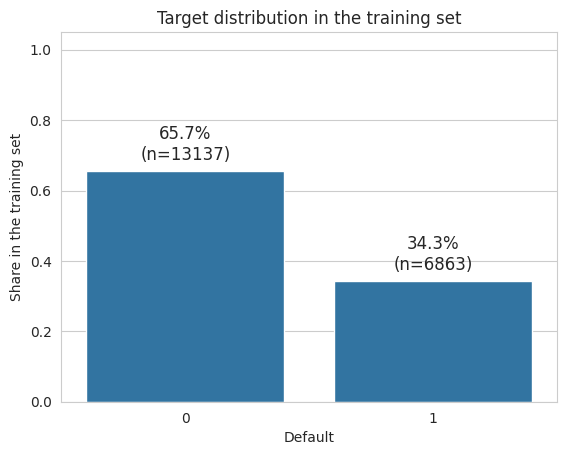

In [ ]:
counts = df_train["Default"].value_counts().sort_index()
props = counts / counts.sum()

fig, ax = plt.subplots()

sns.barplot(x=counts.index.astype(str), y=props.values, ax=ax)

ax.set_xlabel("Default")
ax.set_ylabel("Share in the training set")
ax.set_title("Target distribution in the training set")
ax.set_ylim(0, 1.05)

for i, (p, n) in enumerate(zip(props.values, counts.values)):
    ax.text(i, p + 0.02, f"{p:.1%}\n(n={n})", ha="center", va="bottom", fontsize=12)

plt.show()

**Key takeaways:**

The target distribution shows a moderate class imbalance of roughly **2:1** in favor of non-defaults (Default = 0). The imbalance is not extreme, but it suggests using simple techniques such as **class weighting**. The final handling strategy will be decided during model training and tuning.

___
### **2.2 – Numeric feature distributions**



This section plots histograms for numeric variables (Age, Income, CreditScore, LoanAmount, EmploymentYears, DebtToIncome). The goal is to assess distribution shapes, potential outliers, and skewness, which helps decide whether transformations or scaling might be needed before modeling.

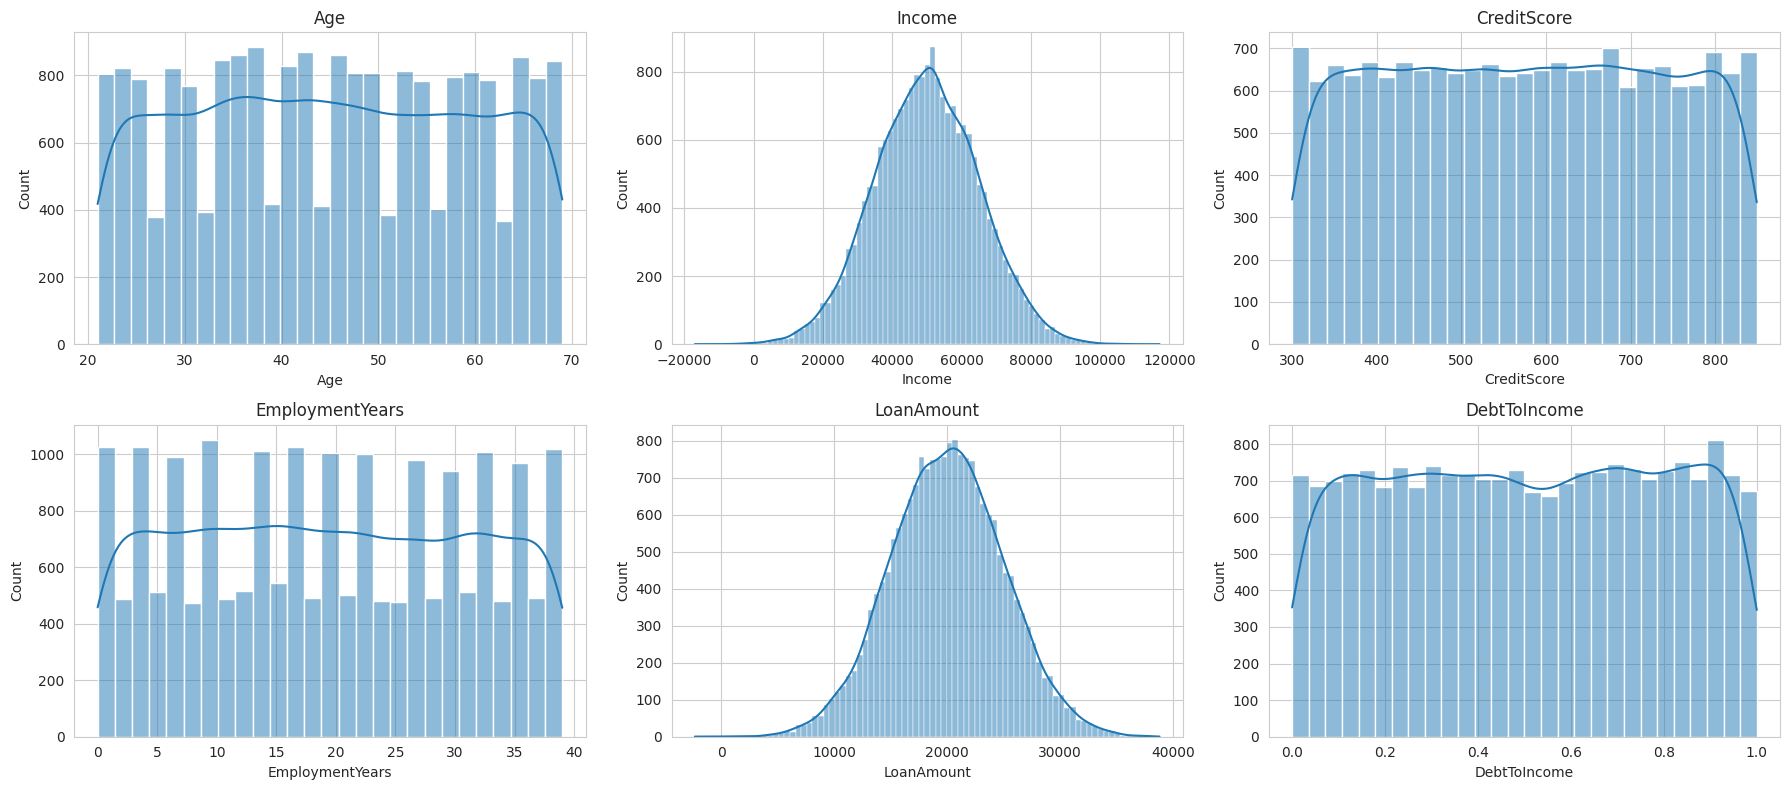

In [ ]:
numeric_cols = ["Age", "Income", "CreditScore", "EmploymentYears", "LoanAmount", "DebtToIncome"]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    sns.histplot(df_train[col], kde=True, ax=ax)
    ax.set_title(col)

for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

**Key takeaways:**

The numeric distributions look regular and do not show extreme outliers. Income and LoanAmount are close to bell-shaped, CreditScore and DebtToIncome are closer to uniform-like distributions, and Age and EmploymentYears resemble quasi-uniform patterns with mild fluctuations. At this stage there is no strong reason for aggressive transformations or clipping; any adjustments can be considered later if a specific model requires it.

<br>

At the same time, the distributions of the Income and LoanAmount variables confirm the presence of individual negative values noted earlier. The characteristics of the distributions of numerical variables indicate a synthetic method of data generation, and negative values are likely to be an unwanted artifact of this process. Due to the synthetic nature of the dataset and the small number of such observations, they will remain in the dataset, with the understanding that in a production scenario, it would be necessary to consider truncating them to zero or removing the relevant rows.


___
### **2.3 – Categorical feature distributions**



This section shows category counts for: EducationLevel, NumDependents, FavoriteColor, and Hobby. Although EducationLevel and NumDependents are stored numerically, they are treated as categorical/ordinal because they represent discrete levels. The goal is to identify rare or dominant categories and anticipate encoding needs.

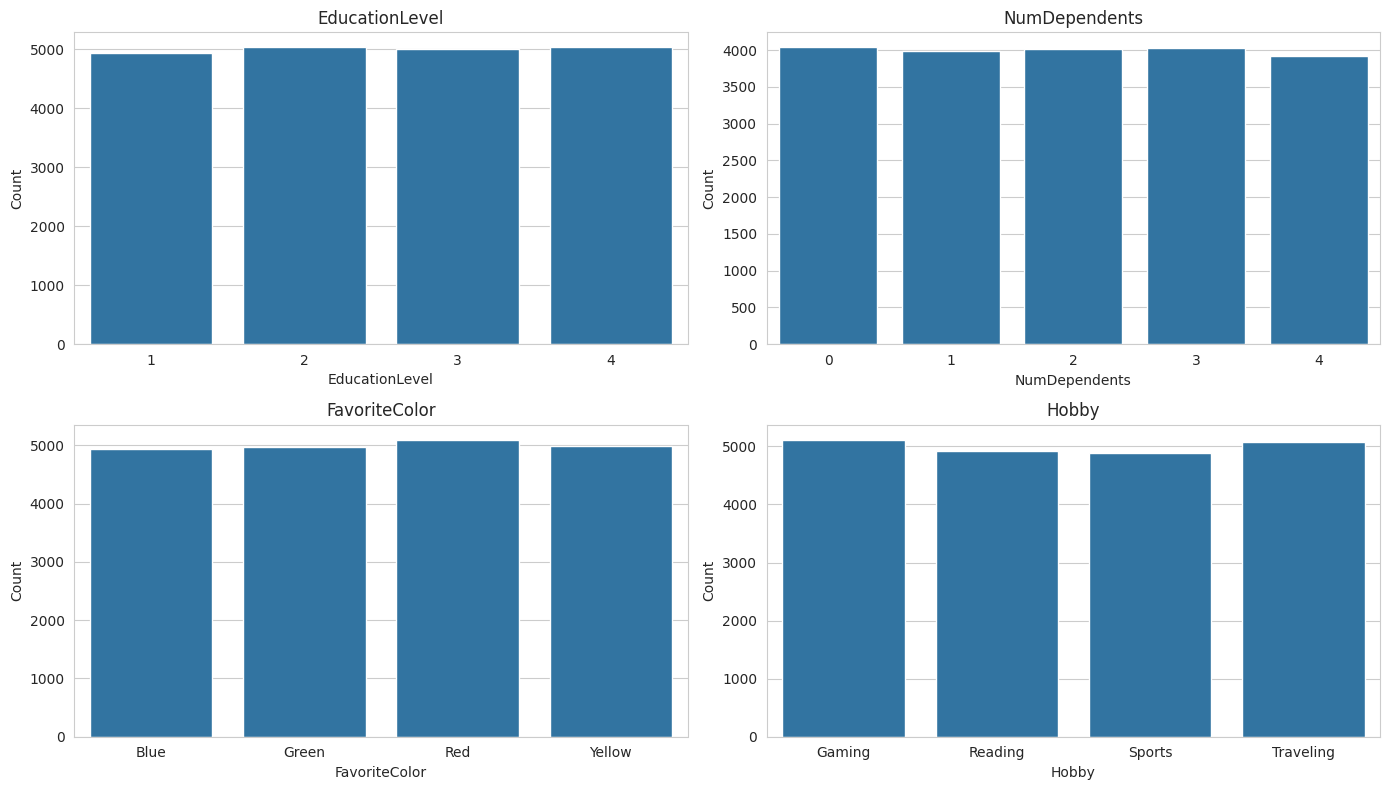

In [ ]:
cat_cols = ["EducationLevel", "NumDependents", "FavoriteColor", "Hobby"]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    values = df_train[col]
    order = sorted(values.unique())
    sns.countplot(x=values, order=order, ax=ax)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


**Key takeaways:**

EducationLevel, NumDependents, FavoriteColor, and Hobby are distributed fairly evenly across categories, with no clearly rare or dominant levels. This makes encoding straightforward (e.g., one-hot / ordinal) and suggests that any predictive differences will come from relationships with Default rather than category sparsity.

___
### **2.4 – Feature relationships with Default**



___
#### **2.4.1 – Boxplots: numeric features vs Default**



As part of this sub-section, box plots will be prepared for numerical variables broken down into groups of solvent customers (Default = 0) and insolvent customers (Default = 1). The aim is to preliminarily check whether the levels of individual variables differ significantly between these groups and which characteristics can potentially distinguish insolvency risk well.

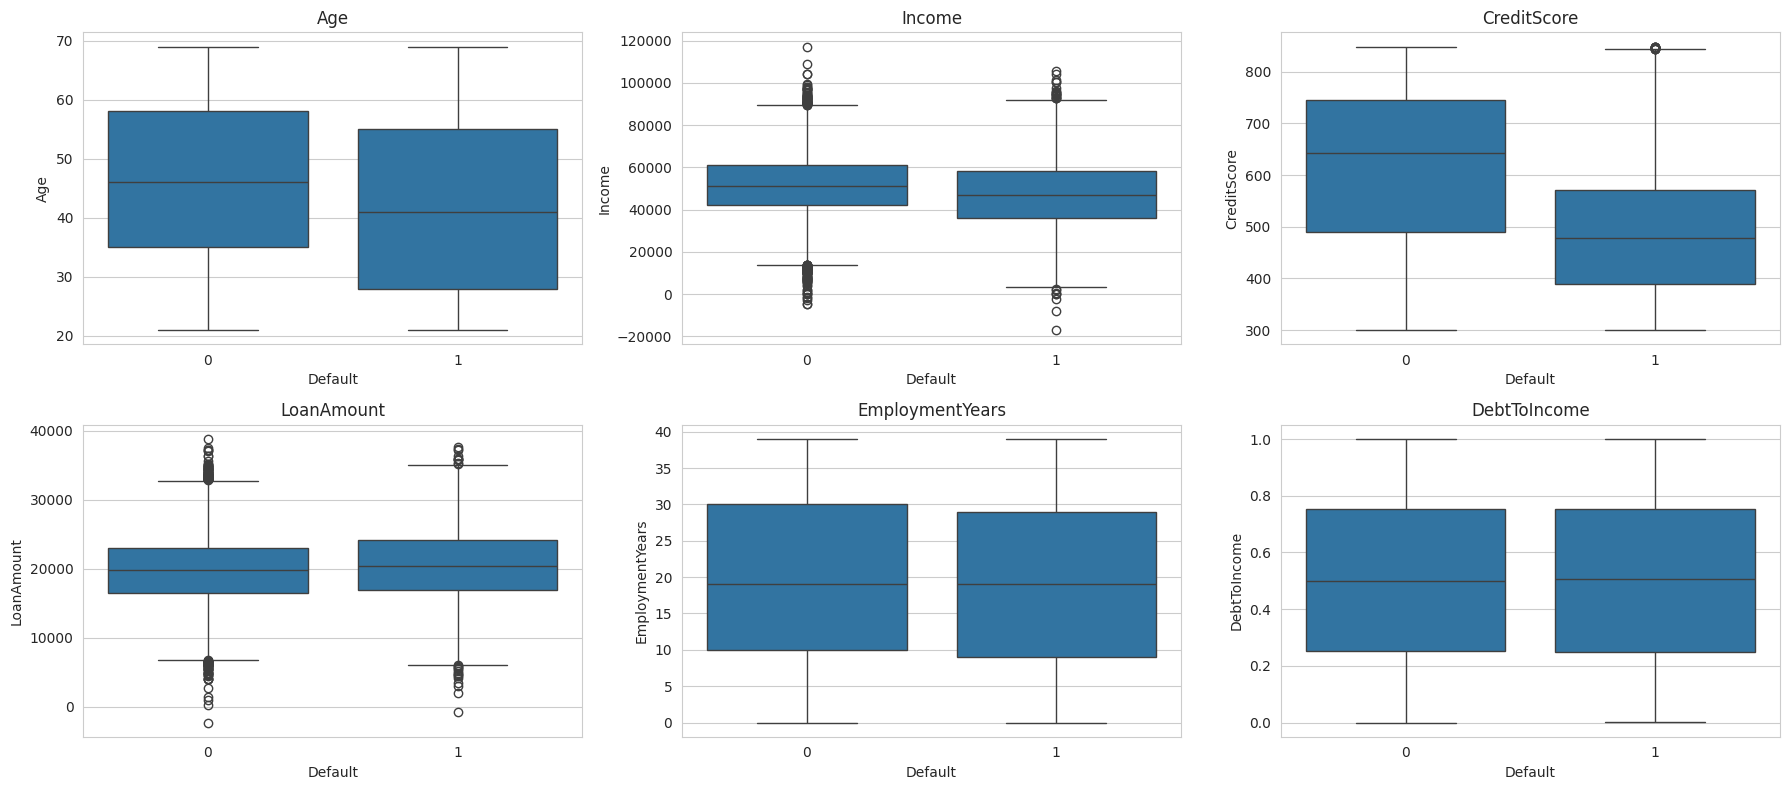

In [ ]:
numeric_cols = ["Age", "Income", "CreditScore", "LoanAmount", "EmploymentYears", "DebtToIncome"]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    sns.boxplot(data=df_train, x="Default", y=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Default")
    ax.set_ylabel(col)

for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


**Feature-level notes:**

- **Age** – the Default = 1 group has a lower median age and the distribution shifts toward younger customers. This suggests higher risk among the youngest, although the groups overlap.  
- **Income** – defaulted customers have slightly lower incomes, with more very low values in the lower tail. This suggests low income may be associated with higher risk.  
- **CreditScore** – the separation is very clear: non-defaults have much higher values, while defaults concentrate at lower scores. This is a strong and intuitive relationship.  
- **LoanAmount** – distributions are similar, with a slightly higher median for Default = 1. This may indicate somewhat higher risk for larger loans, but the effect is not very strong.  
- **EmploymentYears** – slightly shorter tenure for the default group, but the boxes overlap substantially, suggesting a moderate relationship at best.  
- **DebtToIncome** – distributions look very similar across groups, with no clear shift in median or quartiles; it does not look like a strong standalone predictor.

**Key takeaways:**

The boxplots suggest that **CreditScore**, **Income**, and **Age** are the most informative variables for predicting default. **LoanAmount** may add some signal (especially at higher values), while **EmploymentYears** and **DebtToIncome** show limited separation and will need validation in later modeling steps.

___
#### **2.4.2 – Default rate by deciles for numeric features**




This subsection analyzes the share of Default = 1 within decile bins of numeric variables. Each feature is split into 10 equal-frequency bins, and the default rate is computed per bin. The goal is to check whether risk changes monotonically with the feature value, which helps with interpretation and assessing approximate linearity.

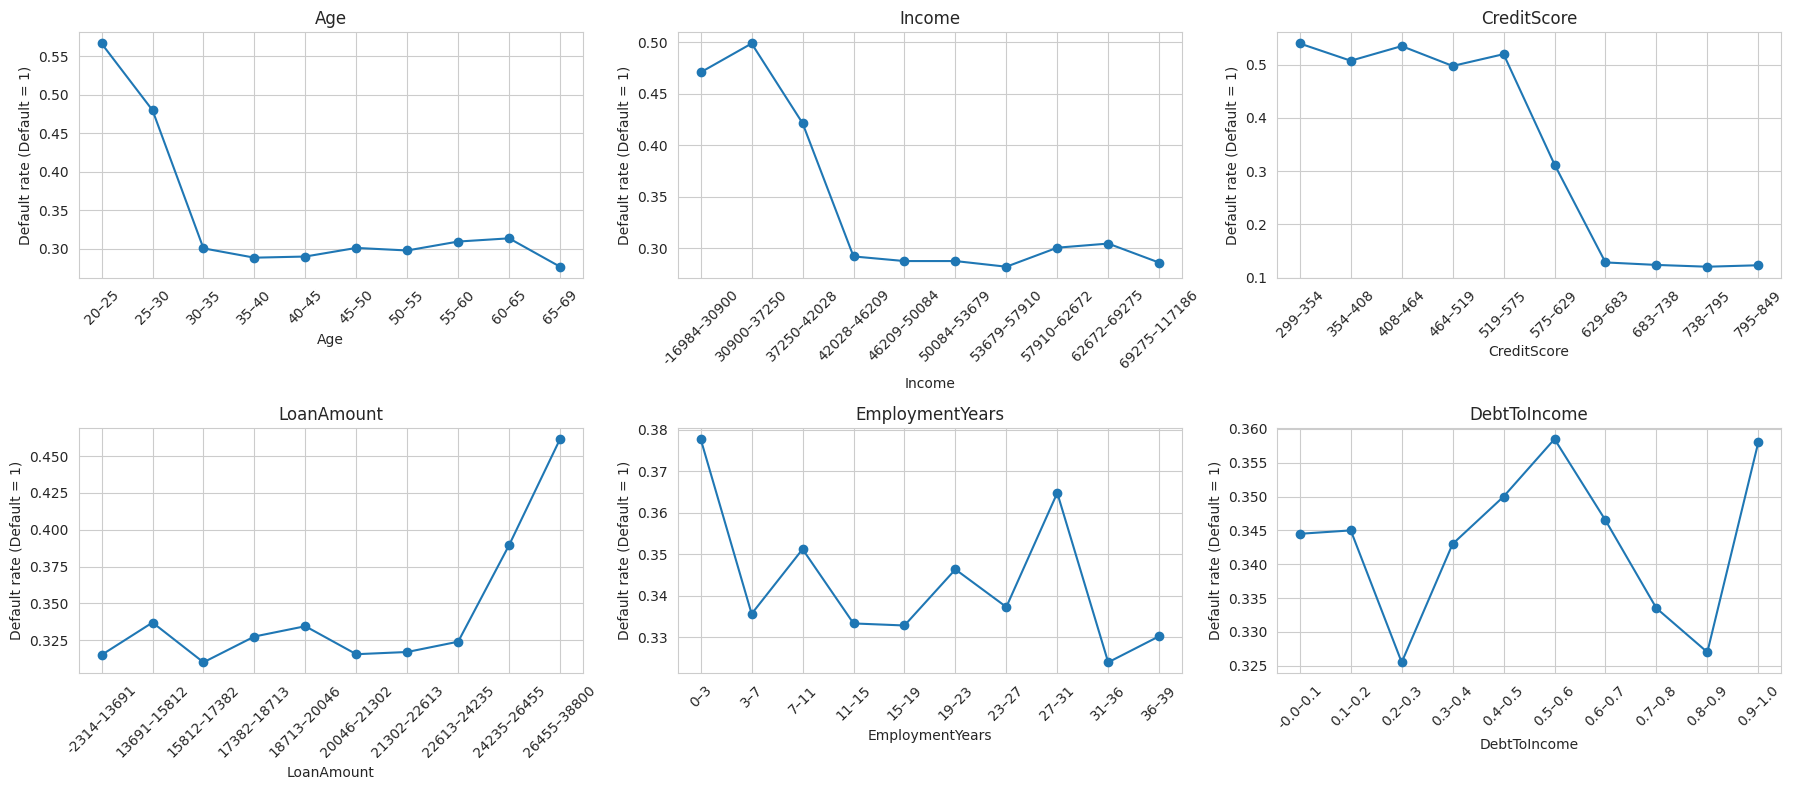

In [ ]:
numeric_cols = ["Age", "Income", "CreditScore", "LoanAmount", "EmploymentYears", "DebtToIncome"]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    bins = pd.qcut(df_train[col], q=10, duplicates="drop")
    default_rate = df_train.groupby(bins, observed=False)["Default"].mean()

    x = np.arange(len(default_rate))
    ax.plot(x, default_rate.values, marker="o")

    if col == "DebtToIncome":
        short_labels = [f"{iv.left:.1f}–{iv.right:.1f}" for iv in default_rate.index]
    else:
        short_labels = [f"{int(iv.left)}–{int(iv.right)}" for iv in default_rate.index]

    ax.set_xticks(x)
    ax.set_xticklabels(short_labels, rotation=45)

    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Default rate (Default = 1)")

for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

**Feature-level notes:**

- **Age** – the two youngest bins (20–25, 25–30) have default rates above 0.5, then risk drops and stabilizes from around 30–35 onwards. This suggests elevated risk among the youngest customers.

- **Income** – default rate is clearly higher in the lowest income deciles and decreases steadily as income increases.  

- **CreditScore** – very strong decline in default rate with increasing score. The lowest bins exceed 0.5, while the highest deciles drop to roughly 0.12–0.13. This is one of the clearest relationships in the dataset.  
- **LoanAmount** – fairly stable in low/medium ranges, with a noticeable increase in the top two deciles. Very large loans appear to materially increase risk.  
- **EmploymentYears** – only small changes across deciles, no clear trend; tenure looks like a weak driver.  
- **DebtToIncome** – slightly wavy but differences are small; no strong ordered relationship is visible.

**Key takeaways:**

Age, Income, CreditScore, and (in the highest range) LoanAmount show an ordered relationship with default risk. EmploymentYears and DebtToIncome show only minor variation, suggesting weaker standalone predictive power. These observations will be useful when interpreting models and feature importance later on.

___
#### **2.4.3 – Default rate for categorical features**

This subsection analyzes the relationship between categorical features (EducationLevel, NumDependents, FavoriteColor, Hobby) and the frequency of Default = 1. For each category, the default rate is computed and shown as a bar chart.

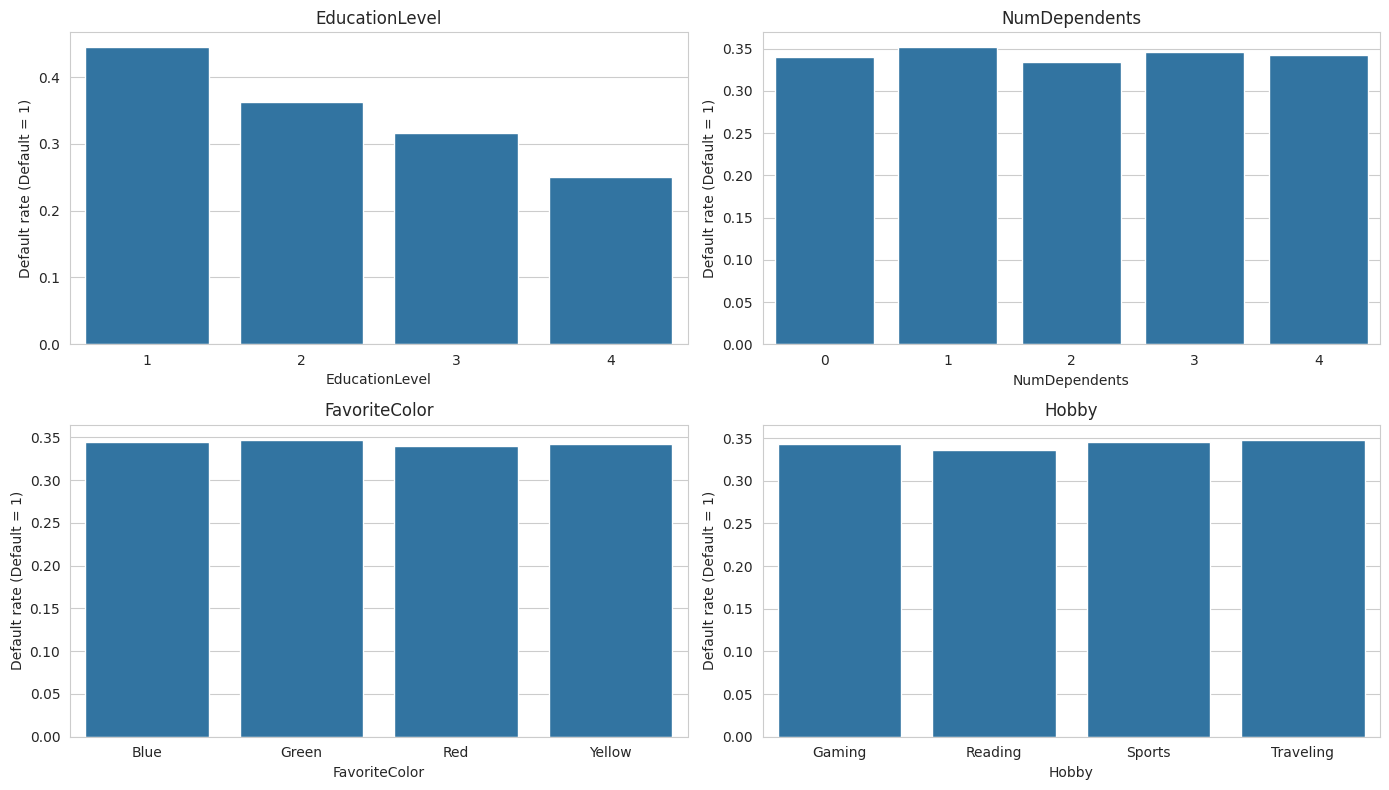

In [ ]:
cat_cols = ["EducationLevel", "NumDependents", "FavoriteColor", "Hobby"]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    default_rate = df_train.groupby(col)["Default"].mean()
    order = sorted(default_rate.index)
    sns.barplot(x=order, y=[default_rate[o] for o in order], ax=ax)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Default rate (Default = 1)")

for ax in axes[len(cat_cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

**Categorical feature notes:**

- **EducationLevel** – default rate decreases clearly as education level increases. The highest risk appears at the lowest education level, and the lowest risk at the highest education level, indicating a meaningful ordered relationship.  
- **NumDependents, FavoriteColor, Hobby** – differences in default rate across categories are very small, with nearly flat patterns. This suggests weak or no relationship with default.

**Key takeaways:**

EducationLevel looks meaningfully related to default risk, while the remaining categorical variables (NumDependents, FavoriteColor, Hobby) do not show clear separation and likely have limited predictive value on their own.

___
#### **2.4.4 – Pearson correlation: numeric/ordinal features vs Default**




This subsection computes Pearson correlations between numeric/ordinal features and the target Default, and visualizes them as a bar chart to compare strength and direction of association.

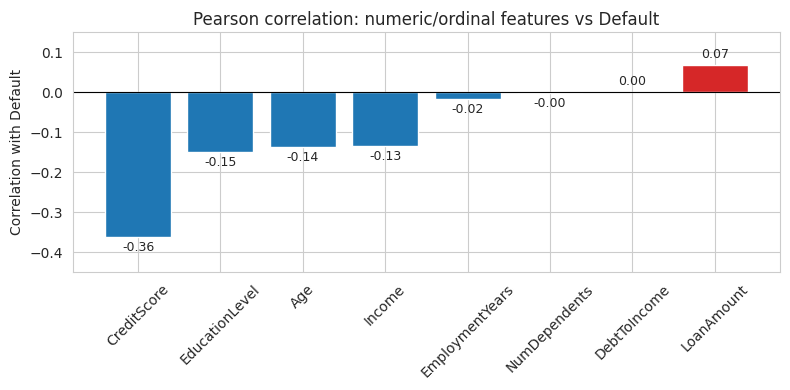

In [ ]:
num_ord_cols = [
    "Age",
    "Income",
    "CreditScore",
    "LoanAmount",
    "EmploymentYears",
    "NumDependents",
    "EducationLevel",
    "DebtToIncome",
]

corr_default = (
    df_train[num_ord_cols + ["Default"]]
    .corr(numeric_only=True)["Default"]
    .drop("Default")
    .sort_values()
)

colors = ["#d62728" if v > 0 else "#1f77b4" for v in corr_default.values]

plt.figure(figsize=(8, 4))
x_pos = np.arange(len(corr_default))

plt.bar(x_pos, corr_default.values, color=colors)

plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Correlation with Default")
plt.title("Pearson correlation: numeric/ordinal features vs Default")
plt.ylim(-0.45, 0.15)

for i, v in enumerate(corr_default.values):
    offset = 0.01 if v >= 0 else -0.01
    va = "bottom" if v >= 0 else "top"
    plt.text(i, v + offset, f"{v:.2f}", ha="center", va=va, fontsize=9)

plt.xticks(x_pos, corr_default.index, rotation=45)
plt.tight_layout()
plt.show()

**Key takeaways:**

Pearson correlations confirm earlier observations: **CreditScore** has the strongest (clearly negative) association with default risk, followed by **Income**, **Age**, and **EducationLevel** (also negative). A small positive correlation for **LoanAmount** suggests slightly higher risk for larger loans, but the effect is much weaker than the role of creditworthiness and income. **DebtToIncome**, **NumDependents**, and **EmploymentYears** are close to zero, indicating limited standalone information about Default.

___
### **2.5 – Correlations and multicollinearity**



This section examines relationships among numeric and ordinal variables. A Pearson correlation matrix is computed and shown as a heatmap to identify strongly related feature pairs, which is relevant for potential multicollinearity in linear models (especially logistic regression).

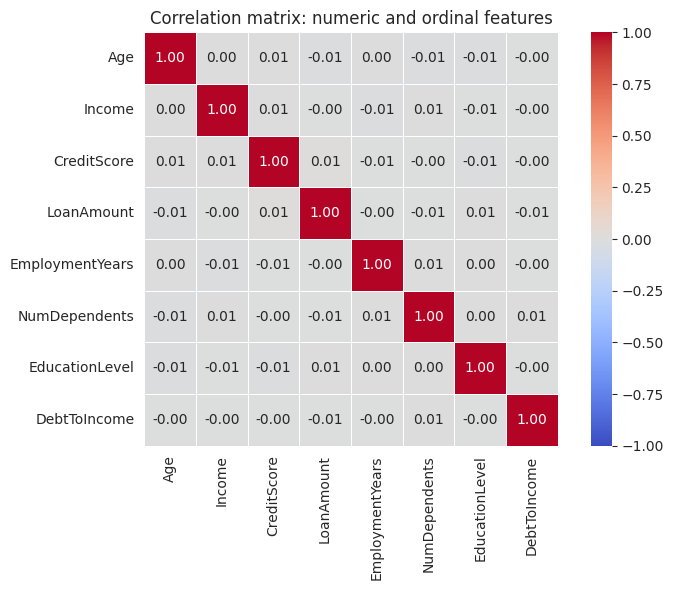

In [ ]:
num_ord_cols = [
    "Age",
    "Income",
    "CreditScore",
    "LoanAmount",
    "EmploymentYears",
    "NumDependents",
    "EducationLevel",
    "DebtToIncome"]

corr_matrix = df_train[num_ord_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    square=True)

plt.title("Correlation matrix: numeric and ordinal features")
plt.tight_layout()
plt.show()


**Key takeaways:**

All Pearson correlations between numeric/ordinal feature pairs are very close to zero. This suggests near-absence of linear dependence among predictors and no meaningful multicollinearity. Combined with earlier Default-related analysis, this indicates that some features carry default-risk signal while not duplicating each other via simple linear correlations.

___
### **2.6 – Summary**



**Feature structure and how they are treated:**  
The exploratory analysis identified the dataset structure and the intended handling of features. The target variable **Default** is binary and indicates the occurrence of a default event. Predictors were grouped into continuous numeric variables (Age, Income, CreditScore, LoanAmount, EmploymentYears, DebtToIncome), ordinal-style numeric variables (EducationLevel, NumDependents), and strictly categorical variables (FavoriteColor, Hobby).

<br>

**Univariate analysis of the target and numeric features:**  
The target distribution in the training set shows a moderate but acceptable class imbalance—roughly two thirds are non-defaults and one third are defaults. The numeric feature distributions reflect the synthetic nature of the data. A few negative observations were treated as a synthetic-data artifact and intentionally left in the dataset, with the note that in a real production scenario they would require separate handling.

<br>

**Bivariate analysis with respect to Default:**  
Relationships with Default highlight a clear set of informative features: CreditScore (strong negative relationship—lower score implies higher risk), Income, Age, and EducationLevel (lower income, younger age, and lower education are associated with higher default rates). Additionally, risk increases in the highest ranges of LoanAmount. Other predictors (DebtToIncome, NumDependents, EmploymentYears, FavoriteColor, Hobby) do not show strong, ordered patterns with default and likely have limited standalone predictive power.

<br>

**Feature correlations and multicollinearity:**  
The Pearson correlation matrix for numeric and ordinal variables shows almost no linear dependence among predictors (correlations are close to zero). This indicates no meaningful multicollinearity, which simplifies both feature selection and coefficient interpretation for linear models.

___
## **3 – Data preparation**
___


**Missing data and unusual values:**  
In the train and test datasets, missing values occur only in the CreditScore variable, and their handling will be carried out in the next stage of the project. In addition, Income and LoanAmount contain a small number of negative observations, which are treated as an artifact of synthetic data generation and are kept in the dataset for the purposes of this project, with a clear reservation regarding their business interpretation.

<br>

**Variable transformations:**  
The analysis of numeric feature distributions did not reveal strong skewness or the presence of extreme values that would hinder modeling. For this reason, additional transformations were not applied, leaving variables on their original scale. Any transformations could be considered only with respect to specific models in later stages of the work.

<br>

**Encoding categorical variables:**  
Categorical variables will be encoded in a way consistent with their nature: ordinal features (EducationLevel, NumDependents) will remain in numeric form, while nominal features (FavoriteColor, Hobby) will be transformed into a zero–one representation. This will ensure they can be directly used by most models.

<br>

**Scaling numeric features:**  
Numeric features with different scales will be standardized, which will facilitate training models sensitive to feature scale (e.g., logistic regression or distance-based models).

<br>

**Cross-validation and data preparation:**    
Encoding categorical variables and standardizing numeric features were performed once at the data preparation stage and then used as a common input base for all models. Thanks to this, hyperparameter tuning with cross-validation is performed on the same, consistent feature representation, which simplifies the comparison of algorithms. An alternative is to perform standardization separately within each fold; however, given the scale and structure of the data, the adopted simplification is practical and does not significantly affect the conclusions.


___
### **3.1 – Handling missing data**


Missing values occur only in **CreditScore** (≈12%). In this project, a simple and transparent approach is used: rows with missing CreditScore are removed from both train and test sets. This avoids making additional assumptions about the missingness mechanism and keeps the preprocessing pipeline easy to reproduce. In a production setting, a common alternative would be to impute CreditScore (e.g., median) and add a “missingness flag”, and then validate the impact of this decision on model performance and stability.


In [ ]:
print("Number of missing values in CreditScore before cleaning:")
print(f"  train: {df_train['CreditScore'].isna().sum()}")
print(f"  test : {df_test['CreditScore'].isna().sum()}")

df_train = df_train.dropna(subset=["CreditScore"]).reset_index(drop=True)
df_test = df_test.dropna(subset=["CreditScore"]).reset_index(drop=True)

print("\nNumber of missing values in CreditScore after cleaning:")
print(f"  train: {df_train['CreditScore'].isna().sum()}")
print(f"  test : {df_test['CreditScore'].isna().sum()}")


Number of missing values in CreditScore before cleaning:
  train: 2383
  test : 608

Number of missing values in CreditScore after cleaning:
  train: 0
  test : 0


___
### **3.2 – Encoding categorical variables**


In this step, categorical variables were encoded for modeling. EducationLevel and NumDependents remain numeric variables with an ordinal nature (a higher value means a higher level of education or a larger number of dependents). The nominal variables FavoriteColor and Hobby, which have no natural order, were transformed using one-hot encoding with OneHotEncoder, fitted on the training set and applied to the test set.


In [ ]:
cat_cols = ["FavoriteColor", "Hobby"]

df_train_prep = df_train.copy()
df_test_prep = df_test.copy()

ohe = OneHotEncoder(drop=None, sparse_output=False, handle_unknown="ignore")

ohe.fit(df_train_prep[cat_cols])

train_ohe = ohe.transform(df_train_prep[cat_cols])
test_ohe = ohe.transform(df_test_prep[cat_cols])

ohe_cols = ohe.get_feature_names_out(cat_cols)

train_ohe_df = pd.DataFrame(train_ohe, columns=ohe_cols, index=df_train_prep.index)
test_ohe_df = pd.DataFrame(test_ohe, columns=ohe_cols, index=df_test_prep.index)

df_train_prep = pd.concat([df_train_prep.drop(columns=cat_cols), train_ohe_df], axis=1)
df_test_prep = pd.concat([df_test_prep.drop(columns=cat_cols), test_ohe_df], axis=1)


___
### **3.3 – Scaling numeric features**


In the next step, numeric features were scaled. Standardization (StandardScaler) was applied to continuous and ordinal numeric variables. The scaler was fitted only on the training set and then used to transform both the training and test sets. Binary (0/1) encoded variables were left unchanged.


In [ ]:
scale_cols = [
    "Age",
    "Income",
    "CreditScore",
    "LoanAmount",
    "EmploymentYears",
    "DebtToIncome",
    "EducationLevel",
    "NumDependents"
]

scaler = StandardScaler()
scaler.fit(df_train_prep[scale_cols])

df_train_prep[scale_cols] = scaler.transform(df_train_prep[scale_cols])
df_test_prep[scale_cols] = scaler.transform(df_test_prep[scale_cols])


___
### **3.4 – Splitting into feature matrices and target vectors**


In the final step of data preparation, the feature matrix X and the target variable y were defined based on the transformed datasets df_train_prep and df_test_prep. The Default variable was separated as the target vector, and the remaining columns form the final set of predictors used in the models.


In [ ]:
X_train = df_train_prep.drop("Default", axis=1)
y_train = df_train_prep["Default"].astype(int)

X_test = df_test_prep.drop("Default", axis=1)
y_test = df_test_prep["Default"].astype(int)

___
## **4 – Model selection and hyperparameter tuning**
___


The goal of this chapter is to select and tune hyperparameters for several competing approaches to predicting **Default**. All models are trained on the same, previously prepared dataset and compared in a consistent way: **grid search** and **cross-validation** on the training set, using **ROC AUC** as the optimization metric.

The results in this chapter should be treated as an initial picture of model quality and as a way to tune the candidates. The final evaluation and selection of the final model will happen later. The models will be refit on the full training data in the selected configurations and then evaluated on the test set, without further tuning.

### **4.1 – Logistic regression**


As a baseline, three logistic regression variants are tested: L2-penalized (Ridge), L1-penalized (LASSO), and an L2 model trained on a feature subset selected by LASSO. Hyperparameter **C** controls regularization strength (smaller C means stronger penalization of model complexity), and class imbalance is handled via class weighting.

___
#### **4.1.1 – Logistic regression with L2 penalty (Ridge)**


In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

log_reg_l2 = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000,
    class_weight = "balanced")

param_grid_l2 = {"C": [0.0005, 0.001, 0.005, 0.01, 0.1]}

grid_l2 = GridSearchCV(
    estimator=log_reg_l2,
    param_grid=param_grid_l2,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1)

grid_l2.fit(X_train, y_train)

print("Best parameters (L2):", grid_l2.best_params_)
print("Mean CV AUC (L2):", grid_l2.best_score_)

Best parameters (L2): {'C': 0.0005}
Mean CV AUC (L2): 0.7676160541113837


___
#### **4.1.2 – Logistic regression with L1 penalty (LASSO)**


In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

log_reg_l1 = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    max_iter=1000,
    class_weight = "balanced")

param_grid_l1 = {"C": [0.0005, 0.001, 0.005, 0.01, 0.1]}

grid_l1 = GridSearchCV(
    estimator=log_reg_l1,
    param_grid=param_grid_l1,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1)

grid_l1.fit(X_train, y_train)

print("Best parameters (L1):", grid_l1.best_params_)
print("Mean CV AUC (L1):", grid_l1.best_score_)

Best parameters (L1): {'C': 0.01}
Mean CV AUC (L1): 0.7675260256735438


___
#### **4.1.3 – Logistic regression with L2 penalty (Ridge) with feature selection**


In [ ]:
best_l1 = grid_l1.best_estimator_
l1_coef = best_l1.coef_.ravel()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

selected_features = X_train.columns[l1_coef != 0]

X_train_red = X_train[selected_features].copy()
X_test_red = X_test[selected_features].copy()

log_reg_l2_red = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000,
    class_weight = "balanced")

param_grid_l2_red = {
    "C": [0.0005, 0.001, 0.005, 0.01, 0.1]}

grid_l2_red = GridSearchCV(
    estimator=log_reg_l2_red,
    param_grid=param_grid_l2_red,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1)

grid_l2_red.fit(X_train_red, y_train)

print("Best parameters (L2_red):", grid_l2_red.best_params_)
print("Mean CV AUC (L2_red):", grid_l2_red.best_score_)

Best parameters (L2_red): {'C': 0.005}
Mean CV AUC (L2_red): 0.767993402798178


___
#### **4.1.4 – Summary**


In [ ]:
best_l2      = grid_l2.best_estimator_
best_l1      = grid_l1.best_estimator_
best_l2_red  = grid_l2_red.best_estimator_

coef_df = pd.DataFrame(index=X_train.columns)

coef_df["L2"] = best_l2.coef_.ravel()
coef_df["L1"] = best_l1.coef_.ravel()

coef_red = pd.Series(
    best_l2_red.coef_.ravel(),
    index=selected_features,
    name="L2_red")

coef_df["L2_red"] = coef_red

coef_df["abs_L2"] = coef_df["L2"].abs()
coef_df_sorted = coef_df.sort_values("abs_L2", ascending=False).drop(columns="abs_L2")

print("\n========= Feature coefficients (in-sample) ==========")
display(coef_df_sorted.head(20))

def eval_model(estimator, X, y):
    y_pred  = estimator.predict(X)
    y_proba = estimator.predict_proba(X)[:, 1]

    return {
        "Train AUC": roc_auc_score(y, y_proba),
        "Train accuracy": (y == y_pred).mean(),
        "Train precision": precision_score(y, y_pred),
        "Train recall": recall_score(y, y_pred),
        "Train F1": f1_score(y, y_pred)}

metrics_dict = {
    "L2": eval_model(best_l2, X_train, y_train),
    "L1": eval_model(best_l1, X_train, y_train),
    "L2_red": eval_model(best_l2_red, X_train_red, y_train)}

metrics_df = pd.DataFrame(metrics_dict)

print("\n===== Evaluation metrics (in-sample) ======")
display(metrics_df)


========= Feature coefficients (in-sample) ==========


,L2,L1,L2_red
CreditScore,-0.559124,-0.892089,-0.875313
EducationLevel,-0.223932,-0.351211,-0.359318
Age,-0.198383,-0.301148,-0.311668
Income,-0.197825,-0.301009,-0.312188
LoanAmount,0.106295,0.152825,0.170713
EmploymentYears,-0.027574,-0.020869,-0.046375
Hobby_Reading,-0.021093,0.000000,NaN
FavoriteColor_Yellow,-0.020500,0.000000,NaN
FavoriteColor_Red,-0.019283,0.000000,NaN
Hobby_Gaming,-0.018089,0.000000,NaN



===== Evaluation metrics (in-sample) ======


,L2,L1,L2_red
Train AUC,0.768357,0.768110,0.768298
Train accuracy,0.693648,0.695294,0.695919
Train precision,0.537659,0.539963,0.541236
Train recall,0.729163,0.722675,0.714024
Train F1,0.618937,0.618099,0.615738


**Conclusions:**

The results of these three variants are very similar: mean ROC AUC from cross-validation is around ~0.768 (differences at the thousandths level), and training metrics are also almost identical.

<br>

Coefficient analysis confirms the EDA findings. The strongest impact on default probability is driven by **CreditScore**, **EducationLevel**, **Age**, and **Income**, and to a lesser extent also **LoanAmount** and **EmploymentYears**. Features related to hobby and color are zeroed out by LASSO, indicating negligible informational value. The L2 model restricted to the feature subset selected by LASSO preserves virtually the same predictive quality while simplifying the model.

<br>

The final usefulness of this model family, compared to tree-based models and neural networks, will be assessed later on the test set in the chapter dedicated to model comparison.


___
### **4.2 – Tree-based models**


The second family includes tree-based models: **Random Forest** and **XGBoost**. Hyperparameters are tuned using grid search with cross-validation and ROC AUC as the metric. Class imbalance is handled using best-practice approaches: `class_weight="balanced"` for Random Forest and `scale_pos_weight` for XGBoost.

___
#### **4.2.1 – Random Forest**



In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_clf = RandomForestClassifier(
    class_weight="balanced",
    n_jobs=-1,
    random_state=42)

param_grid_rf = {
    "n_estimators": [200, 400],
    "max_depth": [5, 10],
    "min_samples_leaf": [5],
    "max_features": ["sqrt"]}

grid_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    error_score="raise")

grid_rf.fit(X_train, y_train)

print("Best parameters (Random Forest):", grid_rf.best_params_)
print("Mean CV AUC (Random Forest):", grid_rf.best_score_)

Best parameters (Random Forest): {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 400}
Mean CV AUC (Random Forest): 0.8173239681547156


___
#### **4.2.2 – XGBoost**



In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
spw = neg / pos

xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
    tree_method="hist",
    scale_pos_weight=spw)

param_grid_xgb = {
    "n_estimators": [200, 400],
    "max_depth": [2, 3, 5],
    "learning_rate": [0.01, 0.02, 0.05],
    "subsample": [0.9],
    "colsample_bytree": [0.9]}

grid_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    error_score="raise")

grid_xgb.fit(X_train, y_train)

print("Best parameters (XGBoost):", grid_xgb.best_params_)
print("Mean CV AUC (XGBoost):", grid_xgb.best_score_)

Best parameters (XGBoost): {'colsample_bytree': 0.9, 'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.9}
Mean CV AUC (XGBoost): 0.8208958862568236


___
#### **4.2.3 – Summary**


In [ ]:
best_rf  = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_

def eval_train(estimator, X, y, threshold=0.5):
    y_proba = estimator.predict_proba(X)[:, 1]
    y_pred  = (y_proba >= threshold).astype(int)

    return {
        "Train AUC": roc_auc_score(y, y_proba),
        "Train Accuracy": accuracy_score(y, y_pred),
        "Train Precision": precision_score(y, y_pred),
        "Train Recall": recall_score(y, y_pred),
        "Train F1": f1_score(y, y_pred)}

if hasattr(X_train, "columns"):
    feature_names = X_train.columns
else:
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

rf_imp  = pd.Series(best_rf.feature_importances_, index=feature_names, name="RF_importance")
xgb_imp = pd.Series(best_xgb.feature_importances_, index=feature_names, name="XGB_importance")

imp_df = pd.concat([rf_imp, xgb_imp], axis=1).fillna(0.0)

sort_by = "XGB_importance"
top_n = 20

imp_df = imp_df.sort_values(sort_by, ascending=False).head(top_n)

print(f"===== Feature importance (Top {top_n}, sorted by: {sort_by}) =====")
display(imp_df)

metrics_df = pd.DataFrame({
    "Random Forest": eval_train(best_rf, X_train, y_train),
    "XGBoost": eval_train(best_xgb, X_train, y_train)})

print("\n===== Metrics (Train, threshold = 0.5) =====")
display(metrics_df)

===== Feature importance (Top 20, sorted by: XGB_importance) =====


,RF_importance,XGB_importance
CreditScore,0.636113,0.496750
Age,0.128449,0.138430
Income,0.125129,0.126848
EducationLevel,0.056255,0.101872
LoanAmount,0.035559,0.068121
EmploymentYears,0.005733,0.017827
Hobby_Traveling,0.000505,0.013023
FavoriteColor_Red,0.000538,0.009929
DebtToIncome,0.007092,0.009784
Hobby_Reading,0.000562,0.009350



===== Metrics (Train, threshold = 0.5) =====


,Random Forest,XGBoost
Train AUC,0.826583,0.824534
Train Accuracy,0.718227,0.725947
Train Precision,0.560360,0.570983
Train Recall,0.808518,0.791549
Train F1,0.661945,0.663413


**Conclusions:**

At the tuning stage, tree-based models perform clearly better than logistic regression: mean CV ROC AUC is about **0.817** for Random Forest and about **0.821** for XGBoost. Both models also confirm the EDA and logistic-selection intuition: feature importance is dominated by **CreditScore, Age, Income, EducationLevel**, while hobby/color-type features appear only marginally at most. This makes the tree-based family a natural top candidate for the final test-set comparison.

___
### **4.3 – Neural networks**


From the neural-network family, one model is used: **TabNet**. Hyperparameters (e.g., layer width and number of steps) are tuned analogously to previous models via grid search and cross-validation on ROC AUC, with class imbalance handled via sample weighting.

#### **4.3.1 – TabNet**


In [ ]:
X_np = X_train.values.astype(np.float32)
y_np = y_train.values.astype(int)

device = "cuda" if torch.cuda.is_available() else "cpu"

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid_tabnet = {
    "width": [4, 8],
    "lr": [0.02, 0.05],
    "n_steps": [3]}

GAMMA = 1.5
LAMBDA_SPARSE = 1e-4

MAX_EPOCHS = 80
PATIENCE = 12
BATCH_SIZE = 1024
VIRTUAL_BATCH_SIZE = 128

results = []
_null = io.StringIO()

for params in ParameterGrid(param_grid_tabnet):
    fold_aucs = []

    for tr_idx, val_idx in cv.split(X_np, y_np):
        X_tr, X_val = X_np[tr_idx], X_np[val_idx]
        y_tr, y_val = y_np[tr_idx], y_np[val_idx]

        w_tr = compute_sample_weight(class_weight="balanced", y=y_tr)

        model = TabNetClassifier(
            n_d=params["width"],
            n_a=params["width"],
            n_steps=params["n_steps"],
            gamma=GAMMA,
            lambda_sparse=LAMBDA_SPARSE,
            optimizer_fn=torch.optim.Adam,
            optimizer_params={"lr": params["lr"]},
            device_name=device, verbose=0)

        with redirect_stdout(_null), redirect_stderr(_null):
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric=["auc"],
                weights=w_tr,
                max_epochs=MAX_EPOCHS,
                patience=PATIENCE,
                batch_size=BATCH_SIZE,
                virtual_batch_size=VIRTUAL_BATCH_SIZE,
                num_workers=0,
                drop_last=False)

        y_val_proba = model.predict_proba(X_val)[:, 1]
        fold_aucs.append(roc_auc_score(y_val, y_val_proba))

    results.append({
        "width": params["width"],
        "n_steps": params["n_steps"],
        "lr": params["lr"],
        "mean_cv_auc": float(np.mean(fold_aucs)),
        "std_cv_auc": float(np.std(fold_aucs))})

results_df = pd.DataFrame(results).sort_values("mean_cv_auc", ascending=False)

best_row = results_df.iloc[0]
best_params_tabnet = {
    "width": int(best_row["width"]),
    "n_steps": int(best_row["n_steps"]),
    "lr": float(best_row["lr"]),
    "gamma": GAMMA,
    "lambda_sparse": LAMBDA_SPARSE}

print("Best parameters (TabNet):", best_params_tabnet)
print("Mean CV AUC (TabNet):", round(float(best_row["mean_cv_auc"]), 5))

Best parameters (TabNet): {'width': 8, 'n_steps': 3, 'lr': 0.02, 'gamma': 1.5, 'lambda_sparse': 0.0001}
Mean CV AUC (TabNet): 0.79943


___
#### **4.3.2 – Summary**


In [ ]:
w_all = compute_sample_weight(class_weight="balanced", y=y_np)

tabnet_best = TabNetClassifier(
    n_d=best_params_tabnet["width"],
    n_a=best_params_tabnet["width"],
    n_steps=best_params_tabnet["n_steps"],
    gamma=best_params_tabnet["gamma"],
    lambda_sparse=best_params_tabnet["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={"lr": best_params_tabnet["lr"]},
    device_name=device,
    verbose=0)

with redirect_stdout(_null), redirect_stderr(_null):
    tabnet_best.fit(
        X_np, y_np,
        eval_set=[(X_np, y_np)],
        eval_metric=["auc"],
        weights=w_all,
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE,
        batch_size=BATCH_SIZE,
        virtual_batch_size=VIRTUAL_BATCH_SIZE,
        num_workers=0,
        drop_last=False
    )

y_proba = tabnet_best.predict_proba(X_np)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

metrics_df = pd.DataFrame({"TabNet": {
    "Train AUC": roc_auc_score(y_np, y_proba),
    "Train Accuracy": accuracy_score(y_np, y_pred),
    "Train Precision": precision_score(y_np, y_pred),
    "Train Recall": recall_score(y_np, y_pred),
    "Train F1": f1_score(y_np, y_pred)}})

print("===== Metrics (Train, threshold = 0.5) =====")
display(metrics_df)

===== Metrics (Train, threshold = 0.5) =====


,TabNet
Train AUC,0.823213
Train Accuracy,0.723676
Train Precision,0.567561
Train Recall,0.798702
Train F1,0.663580


**Conclusions:**

The best TabNet configuration reaches mean CV ROC AUC of about **0.806** with parameters (among others) `width=4`, `n_steps=3`, `lr=0.05`. This is weaker than tree-based models, while the computational cost (tuning/training time) is noticeably higher, so TabNet serves here more as an additional reference point than a final-model favorite.

___
### **4.4 – Summary**


At the level of hyperparameter tuning on the training set with cross-validation, the picture is clear: tree-based models (especially XGBoost) achieve the highest CV ROC AUC (0.821), TabNet is in the middle (0.806), and logistic regression remains a stable, interpretable baseline (0.768). At the same time, the consistency of the “most important predictors” across model families (CreditScore, Age, Income, EducationLevel) strengthens the conclusion that the signal in the data is coherent, while some features (hobby/colors) carry at most marginal information.

In the next part of the project, it will be crucial to separate two stages: (1) refitting the selected models on the training set using the best configurations, and (2) testing on the test set as the final evaluation and final-model choice. At this stage, it is also worth checking the finalist in two variants: using the full feature set and using a reduced set supported both by EDA/LASSO and by tree-based feature importance, to ensure that potential noise does not hurt generalization on the test set.


___
## **5 – Model comparison**
___


After completing hyperparameter tuning on the training set, the selected model configurations move to a comparative evaluation stage on the test set. The goal of this chapter is to reliably compare competing models on data not seen during parameter selection and to indicate the solution that best meets the requirements of default prediction. The analysis includes both metric-based comparison and model behavior assessment using ROC / Precision–Recall curves, calibration curves, and sensitivity to the decision threshold.


### **5.1 – Model evaluation on the test set**


In this step, each considered model is refit on the training set using the optimal hyperparameters selected in Chapter 4, and then evaluated on the test set. For consistent comparison, all models report the same set of metrics (ROC AUC, Average Precision, Brier score, Accuracy, Precision, Recall, F1).


In [ ]:
THRESHOLD = 0.5

def _metrics_from_proba(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "AUC": roc_auc_score(y_true, y_proba),
        "AP": average_precision_score(y_true, y_proba),
        "Brier": brier_score_loss(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)}, y_pred

def _proba_sklearn(model, X):
    return model.predict_proba(X)[:, 1]

def _proba_tabnet(model, X_df):
    return model.predict_proba(X_df.values.astype(np.float32))[:, 1]

best_params_map = {
    "LogReg_L2": grid_l2.best_params_,
    "LogReg_L1": grid_l1.best_params_,
    "LogReg_L2_red": grid_l2_red.best_params_,
    "RandomForest": grid_rf.best_params_,
    "XGBoost": grid_xgb.best_params_,
    "TabNet": best_params_tabnet}

models_map = {
    "LogReg_L2": (best_l2, X_train, X_test, _proba_sklearn),
    "LogReg_L1": (best_l1, X_train, X_test, _proba_sklearn),
    "LogReg_L2_red": (best_l2_red, X_train_red, X_test_red, _proba_sklearn),
    "RandomForest": (best_rf, X_train, X_test, _proba_sklearn),
    "XGBoost": (best_xgb, X_train, X_test, _proba_sklearn),
    "TabNet": (tabnet_best, X_train, X_test, _proba_tabnet)}

pred_store = {}
cm_store = {}
report_store = {}
rows = []

for name, (model, Xtr, Xte, proba_fn) in models_map.items():
    ytr_true = y_train.values.astype(int)
    yte_true = y_test.values.astype(int)

    ytr_proba = proba_fn(model, Xtr)
    yte_proba = proba_fn(model, Xte)

    tr_metrics, ytr_pred = _metrics_from_proba(ytr_true, ytr_proba, threshold=THRESHOLD)
    te_metrics, yte_pred = _metrics_from_proba(yte_true, yte_proba, threshold=THRESHOLD)

    rows.append({
        "Model": name,
        "Train AUC": tr_metrics["AUC"],
        "Test AUC": te_metrics["AUC"],
        "Train AP": tr_metrics["AP"],
        "Test AP": te_metrics["AP"],
        "Train Brier": tr_metrics["Brier"],
        "Test Brier": te_metrics["Brier"],
        "Train Accuracy": tr_metrics["Accuracy"],
        "Test Accuracy": te_metrics["Accuracy"],
        "Train Precision": tr_metrics["Precision"],
        "Test Precision": te_metrics["Precision"],
        "Train Recall": tr_metrics["Recall"],
        "Test Recall": te_metrics["Recall"],
        "Train F1": tr_metrics["F1"],
        "Test F1": te_metrics["F1"]})

    pred_store[name] = {
        "y_train_true": ytr_true,
        "y_train_proba": ytr_proba,
        "y_train_pred": ytr_pred,
        "y_test_true": yte_true,
        "y_test_proba": yte_proba,
        "y_test_pred": yte_pred}

    cm_store[name] = {
        "train": confusion_matrix(ytr_true, ytr_pred),
        "test": confusion_matrix(yte_true, yte_pred)}

    report_store[name] = {
        "train": classification_report(ytr_true, ytr_pred, zero_division=0),
        "test": classification_report(yte_true, yte_pred, zero_division=0)}

results_df = pd.DataFrame(rows).set_index("Model").sort_values("Test AUC", ascending=False)

print(f"===== Results (threshold = {THRESHOLD}) =====")
display(results_df)

===== Results (threshold = 0.5) =====


,Train AUC,Test AUC,Train AP,Test AP,Train Brier,Test Brier,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1,Test F1
Model,,,,,,,,,,,,,,
XGBoost,0.824534,0.818148,0.703157,0.701782,0.173454,0.177632,0.725947,0.717668,0.570983,0.570764,0.791549,0.794041,0.663413,0.664139
RandomForest,0.826583,0.816394,0.710076,0.699998,0.178501,0.182790,0.718227,0.712659,0.560360,0.562611,0.808518,0.820596,0.661945,0.667545
TabNet,0.823213,0.803046,0.700517,0.680080,0.178064,0.188500,0.723676,0.705829,0.567561,0.557065,0.798702,0.796632,0.663580,0.655650
LogReg_L1,0.768110,0.773011,0.606843,0.621702,0.198476,0.197903,0.695294,0.694444,0.539963,0.548418,0.722675,0.740933,0.618099,0.630303
LogReg_L2_red,0.768298,0.772713,0.608308,0.623390,0.197359,0.196964,0.695919,0.694672,0.541236,0.549440,0.714024,0.730570,0.615738,0.627189
LogReg_L2,0.768357,0.772705,0.608197,0.622861,0.204149,0.203843,0.693648,0.693306,0.537659,0.546749,0.729163,0.746114,0.618937,0.631060


**Conclusions:**

After testing six models on the test set, the differences in metrics are relatively small, but tree-based models consistently achieve the highest values in ranking metrics (ROC AUC and AP). XGBoost has the best test ROC AUC, while Random Forest achieves a very similar AUC and, at the 0.5 threshold, slightly better threshold-dependent metrics, suggesting a different precision–recall trade-off. TabNet performs worse than the tree-based models, and its advantage over logistic regression is at most moderate.


___
### **5.2 – Comparative visualizations**


To deepen the comparison beyond numeric metrics, three test-set visualizations are produced: ROC curves (risk ranking quality), Precision–Recall curves (default detection under class imbalance), and calibration curves (agreement between predicted PD and observed default frequencies). This set allows the models to be assessed simultaneously as ranking tools, decision-support tools, and probability estimators.

___
#### **5.2.1 – ROC curves**



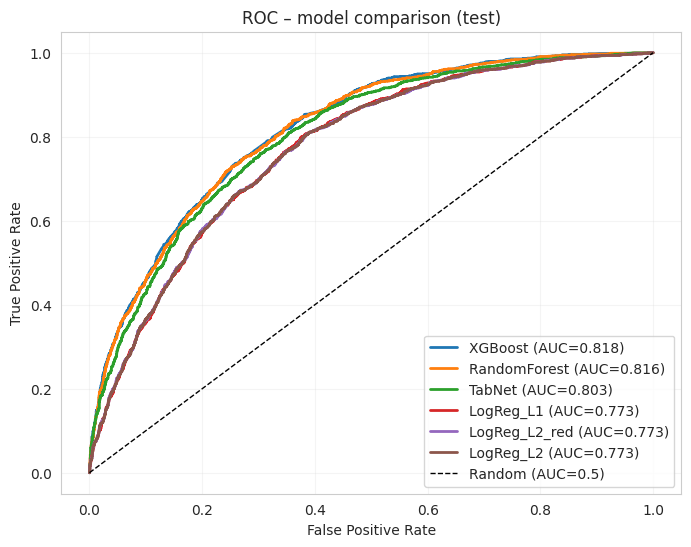

In [ ]:
order = results_df.sort_values("Test AUC", ascending=False).index.tolist()

plt.figure(figsize=(8, 6))

for name in order:
    y_true = pred_store[name]["y_test_true"]
    y_proba = pred_store[name]["y_test_proba"]
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – model comparison (test)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

**Conclusions:**

The curves for XGBoost and Random Forest are slightly closer to the top-left corner over most of the range than the remaining models, confirming the best class separation on the test set (AUC ~0.818 and ~0.816). TabNet is very close, but consistently slightly lower (AUC ~0.808). All logistic regression variants form a clearly lower curve (AUC ~0.773), indicating noticeably weaker discrimination of default vs non-default compared to tree-based models.


___
#### **5.2.2 – Precision–Recall curves + AP**



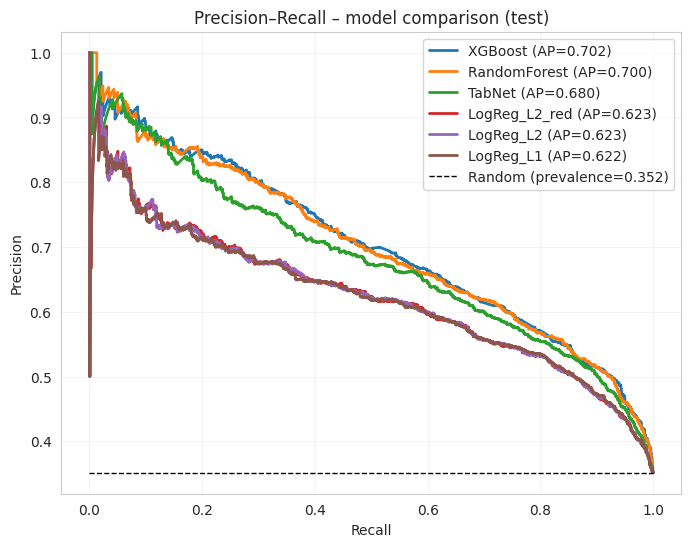

In [ ]:
order = results_df.sort_values("Test AP", ascending=False).index.tolist()

plt.figure(figsize=(8, 6))

for name in order:
    y_true = pred_store[name]["y_test_true"]
    y_proba = pred_store[name]["y_test_proba"]
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.plot(rec, prec, linewidth=2, label=f"{name} (AP={ap:.3f})")

pos_rate = np.mean(pred_store[order[0]]["y_test_true"])
plt.hlines(pos_rate, 0, 1, colors="k", linestyles="--", linewidth=1, label=f"Random (prevalence={pos_rate:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall – model comparison (test)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

**Conclusions:**

The highest curves and the largest AP values are achieved by XGBoost and Random Forest (AP ~0.702 and ~0.700), meaning a more favorable precision–recall trade-off across the full range. TabNet performs in-between (AP ~0.684), while logistic models maintain lower precision for the same recall levels (AP ~0.622–0.623). In practice, this indicates that tree-based models detect defaults most effectively with fewer false alarms.


___
#### **5.2.3 - Calibration Curve**



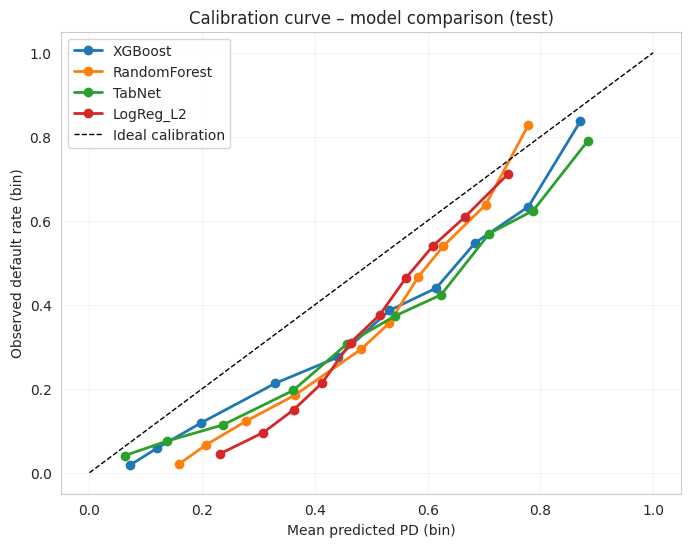

In [ ]:
top3 = results_df.sort_values("Test AUC", ascending=False).index.tolist()[:3]
baseline = "LogReg_L2"
models_to_plot = top3.copy()
if baseline not in models_to_plot and baseline in pred_store:
    models_to_plot.append(baseline)

plt.figure(figsize=(8, 6))

for name in models_to_plot:
    y_true = pred_store[name]["y_test_true"]
    y_proba = pred_store[name]["y_test_proba"]
    frac_pos, mean_pred = calibration_curve(y_true, y_proba, n_bins=10, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o", linewidth=2, label=name)

plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Ideal calibration")
plt.xlabel("Mean predicted PD (bin)")
plt.ylabel("Observed default rate (bin)")
plt.title("Calibration curve – model comparison (test)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

**Conclusions:**

LogReg_L2 stays closest to the ideal line in the central probability range, suggesting the most stable PD calibration. XGBoost, Random Forest, and TabNet show larger deviations in some bins (locally under- or over-estimating risk), even though they perform better in ranking metrics (AUC/AP). This suggests separating ranking quality from the quality of the predicted probability level when choosing the final model.


___
#### **5.2.4 – Summary**



The visualizations confirm the earlier results: in terms of ranking (ROC) and precision–recall performance, tree-based models perform best, with TabNet as an intermediate solution and logistic regression clearly weaker in class separation.

<br>

A different conclusion applies to calibration. Logistic regression is closest to the ideal curve, which is consistent with its probabilistic nature, while tree-based models show larger local deviations in PD level. Therefore, the final model choice should depend on the objective: ranking/default detection vs the quality of PD estimation itself, and the next step (threshold selection) will refine this decision.


___
### **5.3 – Decision-threshold analysis**

In this part, models are evaluated from a decision-making perspective, i.e., after converting predicted PD probabilities into a binary classification decision. Since metrics such as precision, recall, and F1 depend on the decision threshold, two threshold-selection scenarios are analyzed. The threshold is selected individually for each model on the training set and then transferred to the test set for a fair evaluation. The following are considered: (1) a business scenario with a minimum default recall requirement and (2) a technical scenario that maximizes F1.


___
#### **5.3.1 – Scenario I: minimum default recall ≥ 0.80**


In [ ]:
TARGET_RECALL = 0.80

def _decision_metrics(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)}

def _pick_threshold_min_recall(y_true, y_proba, target_recall=0.80):
    p, r, t = precision_recall_curve(y_true, y_proba)
    p, r = p[:-1], r[:-1]
    ok = np.where(r >= target_recall)[0]
    if len(ok) == 0:
        idx = int(np.argmax(r))
        return float(t[idx])
    best_p = np.max(p[ok])
    ok2 = ok[p[ok] == best_p]
    idx = int(ok2[np.argmax(t[ok2])])
    return float(t[idx])

thresholds_recall80 = {}
rows = []

for name, d in pred_store.items():
    ytr_true, ytr_proba = d["y_train_true"], d["y_train_proba"]
    yte_true, yte_proba = d["y_test_true"], d["y_test_proba"]

    thr = _pick_threshold_min_recall(ytr_true, ytr_proba, target_recall=TARGET_RECALL)
    thresholds_recall80[name] = thr

    trm = _decision_metrics(ytr_true, ytr_proba, thr)
    tem = _decision_metrics(yte_true, yte_proba, thr)

    rows.append({
        "Model": name,
        "Threshold": thr,
        "Train Precision": trm["Precision"], "Train Recall": trm["Recall"], "Train F1": trm["F1"], "Train Accuracy": trm["Accuracy"],
        "Test Precision": tem["Precision"], "Test Recall": tem["Recall"], "Test F1": tem["F1"], "Test Accuracy": tem["Accuracy"]})

decision_recall80_df = pd.DataFrame(rows).set_index("Model").sort_values("Test Recall", ascending=False)

print(f"===== Thresholds selected on TRAIN for Recall ≥ {TARGET_RECALL:.2f} =====")
display(decision_recall80_df)


===== 5.3.1: progi dobrane na TRAIN pod Recall ≥ 0.80 =====


,Threshold,Train Precision,Train Recall,Train F1,Train Accuracy,Test Precision,Test Recall,Test F1,Test Accuracy
Model,,,,,,,,,
LogReg_L2_red,0.436759,0.513892,0.800033,0.625805,0.673554,0.524522,0.817358,0.638987,0.675319
LogReg_L2,0.465969,0.515541,0.800200,0.627078,0.675257,0.526118,0.815415,0.639573,0.676913
LogReg_L1,0.443500,0.515655,0.800033,0.627111,0.675370,0.523314,0.814119,0.637101,0.673953
XGBoost,0.498724,0.562064,0.804525,0.661786,0.719419,0.563734,0.813472,0.665960,0.713115
RandomForest,0.510182,0.565765,0.800033,0.662808,0.722257,0.564253,0.807642,0.664358,0.713115
TabNet,0.498839,0.567032,0.800033,0.663677,0.723335,0.555505,0.797280,0.654787,0.704463


**Conclusions:**

In the scenario with a minimum default recall requirement (≥ 0.80), thresholds were selected individually for each model on the training set and then transferred to the test set. On the test set, all models maintain recall at roughly 0.80+, and the best precision–recall trade-off is achieved by XGBoost, followed by Random Forest, then TabNet, while logistic regression variants perform worse. In practice, this means that under a risk-control policy (high coverage of defaults), tree-based models deliver the best decision quality at a comparable recall level.


___
#### **5.3.2 – Scenario II: threshold maximizing F1**


In [ ]:
def _pick_threshold_max_f1(y_true, y_proba):
    p, r, t = precision_recall_curve(y_true, y_proba)
    p, r = p[:-1], r[:-1]
    f1 = (2 * p * r) / (p + r + 1e-12)
    idx = int(np.argmax(f1))
    return float(t[idx])

thresholds_maxf1 = {}
rows = []

for name, d in pred_store.items():
    ytr_true, ytr_proba = d["y_train_true"], d["y_train_proba"]
    yte_true, yte_proba = d["y_test_true"], d["y_test_proba"]

    thr = _pick_threshold_max_f1(ytr_true, ytr_proba)
    thresholds_maxf1[name] = thr

    trm = _decision_metrics(ytr_true, ytr_proba, thr)
    tem = _decision_metrics(yte_true, yte_proba, thr)

    rows.append({
        "Model": name,
        "Threshold": thr,
        "Train Precision": trm["Precision"], "Train Recall": trm["Recall"], "Train F1": trm["F1"], "Train Accuracy": trm["Accuracy"],
        "Test Precision": tem["Precision"], "Test Recall": tem["Recall"], "Test F1": tem["F1"], "Test Accuracy": tem["Accuracy"]})

decision_maxf1_df = pd.DataFrame(rows).set_index("Model").sort_values("Test F1", ascending=False)

print("===== Thresholds selected on TRAIN to maximize F1 =====")
display(decision_maxf1_df)

===== Thresholds selected on TRAIN to maximize F1 =====


,Threshold,Train Precision,Train Recall,Train F1,Train Accuracy,Test Precision,Test Recall,Test F1,Test Accuracy
Model,,,,,,,,,
XGBoost,0.507964,0.575411,0.786392,0.664558,0.729125,0.576159,0.788860,0.665938,0.721767
RandomForest,0.515444,0.580661,0.780236,0.665815,0.732758,0.573942,0.781736,0.661914,0.719262
TabNet,0.500353,0.568115,0.798536,0.663900,0.724130,0.556715,0.794689,0.654749,0.705373
LogReg_L1,0.453536,0.521085,0.789386,0.627770,0.680593,0.531797,0.806995,0.641111,0.682377
LogReg_L2,0.465969,0.515541,0.800200,0.627078,0.675257,0.526118,0.815415,0.639573,0.676913
LogReg_L2_red,0.450470,0.521446,0.784728,0.626552,0.680820,0.531787,0.801813,0.639463,0.682149


**Conclusions:**

In the F1-maximization scenario, thresholds were selected on the training set to obtain the best balance between precision and recall, and then applied to the test set. Also in this variant, the highest test F1 is achieved by XGBoost, Random Forest remains very close, TabNet is intermediate, while logistic models are clearly weaker. The conclusion is consistent with the earlier ranking metrics: regardless of the threshold-selection strategy, tree-based models remain the most competitive final candidates.


___
#### **5.3.3 – Summary**



In both threshold-selection scenarios (Recall ≥ 0.80 and F1 maximization), the model ranking remains consistent: XGBoost achieves the best decision metrics on the test set, Random Forest is very close behind, and the remaining approaches perform worse. Therefore, for the final-model stage, tree-based models remain the primary candidates, with XGBoost as the top choice.


___
## **6 – Final model and summary**
___


The objective of the project was to build a single predictive model that estimates a customer’s probability of default (PD) based on the provided data. For this reason, Chapters 4 and 5 should be treated as a selection and tuning stage: first, three model families were compared using a common hyperparameter-selection methodology (cross-validation and grid search), and then evaluated on the test set in both a ranking perspective and a decision perspective (threshold-dependent). This made it possible to make an informed decision not only about the best modeling approach, but also about configuring the model in a way that delivers the strongest performance on unseen data.

<br>

At the same time, the analysis shows that some evaluation elements (e.g., threshold selection, the precision–recall trade-off, or emphasis on PD calibration) must be aligned with specific business assumptions and error costs. This chapter presents the final model chosen as the end solution under the adopted evaluation criteria, together with the rationale derived from the performed tests and conclusions from previous stages.


___
### **6.1 – Final model selection (XGBoost) and rationale**

XGBoost was selected as the final model. The decision is based on the combined test-set assessment from three perspectives analyzed earlier in parallel: class separation quality, default detection effectiveness under class imbalance, and performance in decision scenarios after threshold selection.

<br>

First, XGBoost achieved the best ranking quality on the test set. In threshold-independent metrics, especially ROC AUC, it was the leader or co-leader among all tested models. In practice, this means the model ranks customers by risk most accurately, i.e., it consistently assigns higher probabilities to higher-risk (default) cases than to non-default cases.

<br>

Second, in metrics that emphasize the default class more strongly (Precision–Recall), XGBoost also remained at the top. This is important because PD tasks typically involve class imbalance and the need to control errors in the positive (default) class. From this perspective, the model maintained the most favorable balance between precision and default coverage.

<br>

Third, the choice of XGBoost was confirmed in the decision analysis. In the business scenario with a minimum default-recall constraint, as well as in the technical scenario of maximizing F1, the model maintained the best or very close-to-best results on the test set. This means that regardless of the adopted decision policy (prioritizing default detection or balancing precision and recall), XGBoost delivered the most stable decision quality when transferring the training-selected threshold to the test data.

<br>

It is worth noting that Random Forest achieved very similar results on some metrics, especially threshold-dependent metrics at selected thresholds. However, overall, XGBoost showed the most consistent advantage in ranking metrics and Precision–Recall analysis. From the project’s objective—building a single final predictive model—XGBoost is the most justified choice as the best-performing solution on the test set, while still allowing further threshold customization and potential PD calibration depending on business requirements.

___
### **6.2 – Final model evaluation**

This section performs the final evaluation of the selected XGBoost model on the test set. The analysis includes a set of prediction-quality metrics, a confusion matrix for the decision threshold selected in the threshold-selection stage (max F1), and a visualization of the predicted PD distribution with correct and incorrect classification cases.

___
#### **6.2.1 – Final model metrics**


In [ ]:
FINAL_MODEL = "XGBoost"
FINAL_SCENARIO = "maxf1"

if FINAL_SCENARIO == "recall80":
    thr_final = float(decision_recall80_df.loc[FINAL_MODEL, "Threshold"])
else:
    thr_final = float(decision_maxf1_df.loc[FINAL_MODEL, "Threshold"])

ytr_true = pred_store[FINAL_MODEL]["y_train_true"]
ytr_proba = pred_store[FINAL_MODEL]["y_train_proba"]
yte_true = pred_store[FINAL_MODEL]["y_test_true"]
yte_proba = pred_store[FINAL_MODEL]["y_test_proba"]

def _metrics_block(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    return pd.Series({
        "ROC AUC": roc_auc_score(y_true, y_proba),
        "AP": average_precision_score(y_true, y_proba),
        "Brier": brier_score_loss(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "Threshold": thr})

m_train = _metrics_block(ytr_true, ytr_proba, thr_final)
m_test = _metrics_block(yte_true, yte_proba, thr_final)

metrics_df = pd.DataFrame({"Train": m_train, "Test": m_test})
metrics_df = metrics_df.loc[["Threshold","ROC AUC","AP","Brier","Accuracy","Precision","Recall","F1"]]

display(metrics_df.style.format("{:.4f}").set_caption(f"XGBoost – metrics (threshold from 5.3: {FINAL_SCENARIO}, thr={thr_final:.4f})"))

,Train,Test
Threshold,0.5080,0.5080
ROC AUC,0.8245,0.8181
AP,0.7032,0.7018
Brier,0.1735,0.1776
Accuracy,0.7291,0.7218
Precision,0.5754,0.5762
Recall,0.7864,0.7889
F1,0.6646,0.6659


**Conclusions:**

On the test set, the model reaches ROC AUC = 0.818 and AP = 0.702, which confirms a strong ability to separate default vs non-default when ranking risk. For the threshold thr = 0.508 (F1 optimization), the model achieves Precision = 0.576, Recall = 0.789, and F1 = 0.666, indicating a reasonable compromise between the number of detected defaults and the number of false alarms. At the same time, Brier = 0.178 suggests a moderately good quality of probability-level estimation.


___
#### **6.2.2 – Confusion matrix**


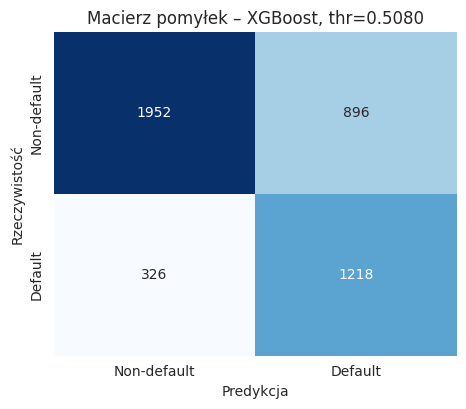

In [ ]:
yte_pred = (yte_proba >= thr_final).astype(int)
cm = confusion_matrix(yte_true, yte_pred)

plt.figure(figsize=(5.2, 4.2))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", cbar=False,
    xticklabels=["Non-default", "Default"],
    yticklabels=["Non-default", "Default"])

plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title(f"Confusion matrix – {FINAL_MODEL}, thr={thr_final:.4f}")
plt.show()

**Conclusions:**

For thr = 0.508, the model correctly classifies 1952 non-default cases (TN) and 1218 default cases (TP). The main source of errors are 896 false alarms (FP), while the number of missed defaults (FN) is 326, which is consistent with a threshold selected to keep recall relatively high at an acceptable precision level.


___
#### **6.2.3 – Predicted PD distribution and error analysis**


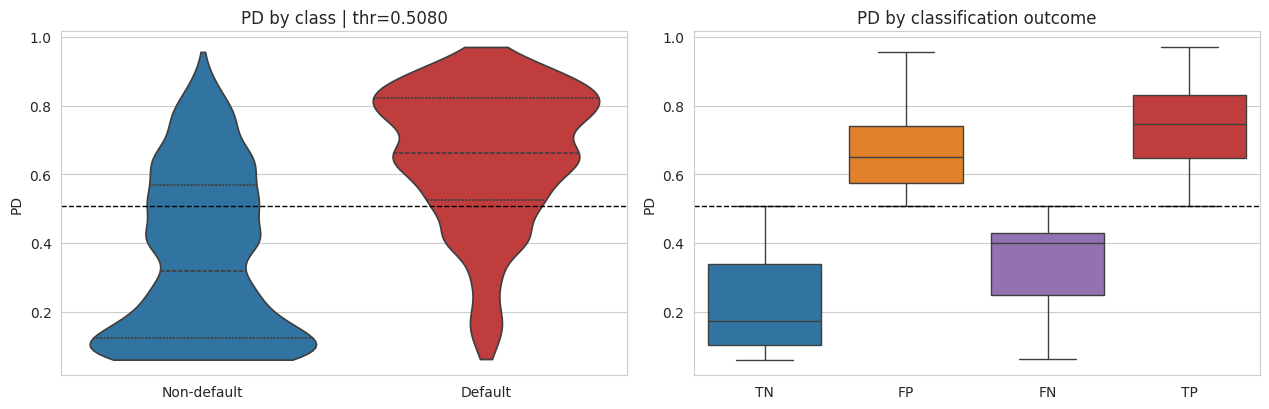

In [ ]:
thr_final = float(decision_maxf1_df.loc[FINAL_MODEL, "Threshold"])

yte_true = pred_store[FINAL_MODEL]["y_test_true"]
yte_proba = pred_store[FINAL_MODEL]["y_test_proba"]

df = pd.DataFrame({"y_true": yte_true, "pd": yte_proba})
df["y_pred"] = (df["pd"] >= thr_final).astype(int)

df["case"] = "TN"
df.loc[(df["y_true"] == 0) & (df["y_pred"] == 1), "case"] = "FP"
df.loc[(df["y_true"] == 1) & (df["y_pred"] == 0), "case"] = "FN"
df.loc[(df["y_true"] == 1) & (df["y_pred"] == 1), "case"] = "TP"

df["Class"] = df["y_true"].map({0: "Non-default", 1: "Default"})

palette_class = {"Non-default": "#1f77b4", "Default": "#d62728"}
palette_cases = {"TN": "#1f77b4", "FP": "#ff7f0e", "FN": "#9467bd", "TP": "#d62728"}
order_cases = ["TN", "FP", "FN", "TP"]

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.2))

sns.violinplot(
    data=df, x="Class", y="pd", hue="Class",
    inner="quartile", cut=0, palette=palette_class,
    legend=False, ax=axes[0])

axes[0].axhline(thr_final, color="black", linestyle="--", linewidth=1)
axes[0].set_title(f"PD by class | thr={thr_final:.4f}")
axes[0].set_xlabel("")
axes[0].set_ylabel("PD")

sns.boxplot(
    data=df, x="case", y="pd", order=order_cases, hue="case",
    palette=palette_cases, ax=axes[1], legend=False)

axes[1].axhline(thr_final, color="black", linestyle="--", linewidth=1)
axes[1].set_title("PD by classification outcome")
axes[1].set_xlabel("")
axes[1].set_ylabel("PD")

plt.tight_layout()
plt.show()

**Conclusions:**

The predicted-PD distributions for the two classes are clearly shifted, but they still partially overlap around the decision threshold, which corresponds to the model’s highest-uncertainty region. The TN/FP/FN/TP breakdown shows that most errors concentrate near the borderline zone around the threshold (FP just above and FN just below), indicating that the threshold choice strongly affects the precision–recall trade-off and can be tuned to match a target risk policy.


___
### **6.3 – Final model interpretability**


In this section, the final model’s behavior on the test data is interpreted. The goal is to show which information the model effectively relies on and how individual features push the predicted PD up or down. A two-track approach is used: first, global feature importance structure is shown (SHAP – average impact), then the distribution and direction of feature impact for individual observations (SHAP beeswarm). Finally, a control test checks whether restricting the input to key variables improves the final model’s results, which closes the question of whether feature reduction is meaningful for this specific problem.

___
#### **6.3.1 – SHAP: global feature importance**



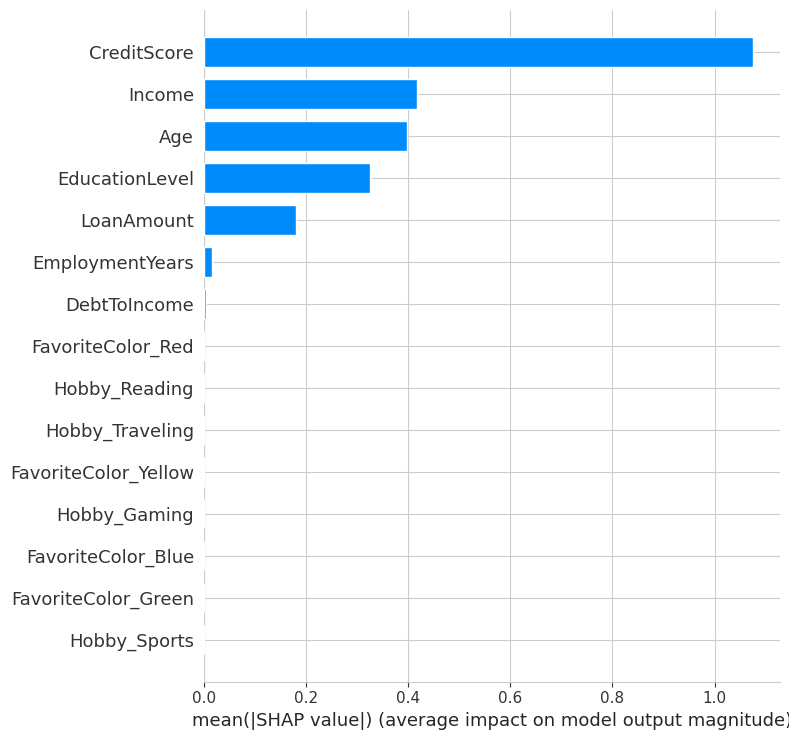

In [ ]:
X_shap = X_test.sample(n=min(1500, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=15, show=True)

**Conclusions:**

The results consistently confirm observations from earlier stages. XGBoost predictions are driven primarily by CreditScore and then—clearly less strongly—by Income, Age, EducationLevel, and LoanAmount. The remaining variables have a marginal impact.


___
#### **6.3.2 – SHAP: direction and distribution of feature impact**


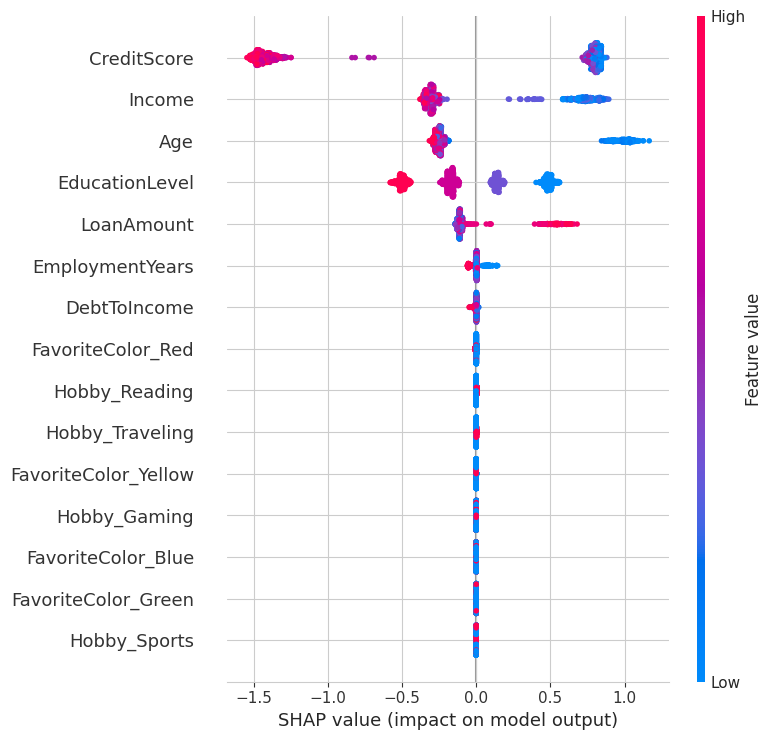

In [ ]:
X_shap = X_test.sample(n=min(1500, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, max_display=15, show=True)

**Conclusions:**

The SHAP distribution plot shows the direction of feature impact. Lower CreditScore and lower Income consistently push predictions toward higher PD, while higher values of these features push PD downward. For Age, LoanAmount, and EducationLevel the impact is more segmented (typical for variables with discrete levels), but the direction of the relationships remains consistent with intuition and earlier results.


___
#### **6.3.3 – Control test: full vs reduced feature set**


In [ ]:
thr_final = float(decision_maxf1_df.loc[FINAL_MODEL, "Threshold"])

base_cols = ["CreditScore", "Age", "Income", "LoanAmount"]
reduced_cols = [c for c in X_train.columns if (c in base_cols) or c.startswith("EducationLevel")]

X_train_red = X_train[reduced_cols]
X_test_red = X_test[reduced_cols]

xgb_full = clone(best_xgb).fit(X_train, y_train)
xgb_red = clone(best_xgb).fit(X_train_red, y_train)

def eval_block(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    return {
        "ROC AUC": roc_auc_score(y_true, y_proba),
        "AP": average_precision_score(y_true, y_proba),
        "Brier": brier_score_loss(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)}

rows = []
for name, model, Xtr, Xte in [
    ("XGB_full", xgb_full, X_train, X_test),
    ("XGB_reduced", xgb_red, X_train_red, X_test_red),
]:
    tr_proba = model.predict_proba(Xtr)[:, 1]
    te_proba = model.predict_proba(Xte)[:, 1]
    row = {"Model": name, "N_features": Xtr.shape[1], "Threshold": thr_final}
    row.update({f"Train {k}": v for k, v in eval_block(y_train.values.astype(int), tr_proba, thr_final).items()})
    row.update({f"Test {k}": v for k, v in eval_block(y_test.values.astype(int), te_proba, thr_final).items()})
    rows.append(row)

res_df = pd.DataFrame(rows).set_index("Model")
display(res_df.style.format("{:.4f}"))
print("Reduced columns:", reduced_cols)


,N_features,Threshold,Train ROC AUC,Train AP,Train Brier,Train Accuracy,Train Precision,Train Recall,Train F1,Test ROC AUC,Test AP,Test Brier,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,,,,,,,,,,,
XGB_full,16.0000,0.5080,0.8245,0.7032,0.1735,0.7291,0.5754,0.7864,0.6646,0.8181,0.7018,0.1776,0.7218,0.5762,0.7889,0.6659
XGB_reduced,5.0000,0.5080,0.8237,0.7021,0.1736,0.7364,0.5891,0.7515,0.6605,0.8177,0.7006,0.1778,0.7281,0.5879,0.7578,0.6621


Reduced columns: ['Age', 'Income', 'CreditScore', 'LoanAmount', 'EducationLevel']


**Conclusions:**

The control test (performed earlier during development and formalized in this chapter) shows that restricting the input to key variables does not improve predictive quality. Results remain very close, and in this run a slight deterioration is observed. In practice, this means that for XGBoost keeping the full feature set is safe because the model itself marginalizes low-information variables. Reduction would mainly make sense when computation time or deployment simplicity is the priority rather than quality gains.


___
### **6.4 – Limitations and improvement ideas**


The results obtained in this project should be interpreted in the context of several important limitations. First, missing-data decisions were made under the assumption of minimal intervention and process consistency, rather than based on a formal credit policy, regulations, or bank operational requirements. In practice, the imputation method and acceptable missing-data handling strategies should follow the organization’s standards, process auditability requirements, and data-governance rules. Alternatives include model-based imputation, a dedicated missingness flag, or a separate decision path for incomplete records.

<br>

Second, model tuning was performed using ROC AUC, which is a sensible choice for risk-ranking evaluation, but it is not always optimal for operational decisions. In real PD use cases, it is typically necessary to set the decision threshold in line with error costs, process capacity, and the desired default-capture level, and often to work on calibration if the model is to be used as a probability estimate (not only a ranking score).

<br>

Third, validation. The applied train/test split and cross-validation ensure model comparability, but in production it would be useful to add temporal stability tests, drift analysis, and robustness checks across alternative random splits. It can also be helpful to quantify metric uncertainty, especially since differences between the best models were small.

<br>

On the practical improvement side, three directions are worth considering. The first is decision-process refinement: explicitly define business scenarios and select thresholds and KPIs accordingly, rather than treating 0.5 as a default threshold. The second is to extend interpretability toward case-level explanations: for selected high-risk cases, report local SHAP values to support business and audit communication. The third is deployment structuring: bundle preprocessing and the model into a single pipeline, add post-deployment monitoring for metrics and calibration, and define an interval re-training procedure.

___
### **6.5 – Final summary**


The objective of the project was to build a predictive model for assessing customers’ probability of default based on training data (20,000 observations), test data (5,000 observations), and a feature set describing, among others, the customer profile and loan parameters.

<br>

During the work, a complete process was carried out: data analysis, feature preparation and transformations, and then a comparison of several modeling approaches. A key element was model selection based on ranking metrics on the test set in order to consciously choose the tool that best separates default and non-default customers. The comparison results showed that tree-based models achieved the best risk-ranking quality, and XGBoost obtained the highest test ROC AUC.

<br>

XGBoost was therefore adopted as the final model, and the decision threshold was selected using the F1-maximization scenario (thr = 0.508). On the test set, the model achieves ROC AUC = 0.818 and AP = 0.702, and at the selected threshold it reaches Precision = 0.576, Recall = 0.789, and F1 = 0.666. In practice, this indicates a reasonable compromise between capturing defaults and limiting false alarms. At the same time, it is clear that the threshold decision strongly affects the precision–recall trade-off and can be tuned to match the target risk policy.

<br>

As part of the final-model interpretation, feature importance was analyzed, which confirmed earlier observations from EDA and baseline models: the prediction is driven primarily by a few key variables (especially CreditScore, and then, among others, Income, Age, EducationLevel, and LoanAmount), while the remaining features add marginal information. Additionally, a control test compared the model on the full vs reduced feature set. The reduction did not improve predictive quality, and differences were small, which supports keeping the full input feature set in the final version.

<br>

As a result, the project delivers not only a working final model but also a justified, measurable model-selection path and an interpretation of which information the model actually relies on. Further improvements—such as a more policy-aligned missing-data strategy, threshold selection based on error costs, potential PD calibration, and temporal stability validation—are documented in the limitations and recommendations.